# Loading Dataset

In [1]:
import pandas as pd
import os

def load_etf_data_with_date(directory):
    """Loads ETF data, parses DateTime, and prepares for correlation analysis.

    Args:
        directory (str): Path to the directory containing the ETF data files.

    Returns:
        pd.DataFrame: Combined DataFrame with DateTime parsing and company labels.
    """
    if not os.path.isdir(directory):
        print(f"Error: The directory '{directory}' does not exist.")
        return None

    all_data = []

    for filename in os.listdir(directory):
        if filename.endswith(".us.txt"):
            company_name = filename[:-7]  # Extract company name
            filepath = os.path.join(directory, filename)

            try:
                # Read file
                df = pd.read_csv(filepath, sep=",")

                # Ensure required columns and parse DateTime
                if "Date" in df.columns and "Close" in df.columns:
                    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
                    df.dropna(subset=["Date"], inplace=True)  # Drop rows with invalid dates
                    df["company_name"] = company_name
                    df = df[["Date", "Close", "company_name"]]  # Keep relevant columns
                    all_data.append(df)
                else:
                    print(f"Warning: Missing required columns in {filename}. Skipping.")
            except Exception as e:
                print(f"An error occurred while processing {filename}: {e}")

    if all_data:
        combined_data = pd.concat(all_data, ignore_index=True)
        return combined_data
    else:
        print("No valid data files found in the directory.")
        return None

In [2]:
def filter_companies_with_apple(data, company):
    """Filters companies with overlapping dates with company and prepares data for correlation analysis.

    Args:
        data (pd.DataFrame): Pivoted DataFrame with companies as columns and Date as index.
        company (str): The column name for company in the DataFrame.

    Returns:
        pd.DataFrame: Filtered DataFrame with only companies that have data in common with Apple.
    """
    if company not in data.columns:
        print(f"Error: {company} not found in the data.")
        return None

    # Identify dates where Apple has data
    apple_dates = data[company].dropna().index

    # Filter data to include only these dates
    filtered_data = data.loc[apple_dates]

    # Drop companies with no data on these dates
    filtered_data = filtered_data.dropna(axis=1, how="all")

    return filtered_data


In [3]:
def prepare_correlation_data(data):
    """Prepares data for correlation analysis by pivoting on Date.

    Args:
        data (pd.DataFrame): Combined DataFrame with Date and Close prices.

    Returns:
        pd.DataFrame: Pivoted DataFrame with companies as columns and Date as index.
    """
    pivot_data = data.pivot(index="Date", columns="company_name", values="Close")
    return pivot_data

In [4]:
directory_path = "/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks"
etf_data = load_etf_data_with_date(directory_path)

An error occurred while processing sbt.us.txt: No columns to parse from file
An error occurred while processing srva.us.txt: No columns to parse from file
An error occurred while processing pxus.us.txt: No columns to parse from file
An error occurred while processing stnl.us.txt: No columns to parse from file
An error occurred while processing bolt.us.txt: No columns to parse from file
An error occurred while processing send.us.txt: No columns to parse from file
An error occurred while processing bbrx.us.txt: No columns to parse from file
An error occurred while processing scci.us.txt: No columns to parse from file
An error occurred while processing scph.us.txt: No columns to parse from file
An error occurred while processing gnst.us.txt: No columns to parse from file
An error occurred while processing wspt.us.txt: No columns to parse from file
An error occurred while processing boxl.us.txt: No columns to parse from file
An error occurred while processing vist.us.txt: No columns to par

In [5]:
# Example Usage
if etf_data is not None:
    # Prepare data for correlation
    correlation_data = prepare_correlation_data(etf_data)

    # Filter data to retain only companies with common data with Apple
    filtered_correlation_data = filter_companies_with_apple(correlation_data, company="aple")

    if filtered_correlation_data is not None:
        # Calculate correlation matrix
        correlation_matrix = filtered_correlation_data.corr()

        # Display correlation with Apple
        apple_correlation = correlation_matrix["aple"].sort_values(ascending=False)
    else:
        print("No companies with common data with Apple.")
else:
    print("Failed to load or process data.")

In [6]:
mask = (apple_correlation.notna()) & (apple_correlation>=0.83)
list(apple_correlation[mask].index)

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


['vtc',
 'flkr',
 'aple',
 'divb',
 'gabr',
 'apls',
 'atacu',
 'rndv',
 'mxdu',
 'rglb',
 'dmrl',
 'amh_g',
 'fxjp',
 'useq',
 'flgb',
 'fmdg',
 'alna',
 'smmd',
 'lovw',
 'umh_c',
 'two_b',
 'vntr',
 'eqrr',
 'edow',
 'rnmc',
 'tcf_b-cl',
 'ggzrw',
 'rnlc',
 'fanz',
 'amca',
 'gssc',
 'nly_f',
 'jpm_d-cl',
 'refa',
 'ccor',
 'mfus',
 'euxl',
 'fng',
 'dlr_j',
 'rnsc',
 'maga',
 'wexp',
 'flmb',
 'sect',
 'ori',
 'gsew',
 'usmf',
 'payx',
 'tpgh-ws',
 'mfdx',
 'bdge',
 'hydb',
 'aspu',
 'nksh']

In [7]:
mask = etf_data['company_name'].isin(list(apple_correlation[mask].index))
etf_dataframe = etf_data.loc[mask].copy()
etf_dataframe

Date   Close company_name
1058795  2017-11-06  10.000         lovw
1058796  2017-11-07  11.960         lovw
1058797  2017-11-08  12.400         lovw
1146258  2017-08-07  50.091         dmrl
1146259  2017-08-10  49.552         dmrl
...             ...     ...          ...
14641596 2017-11-06  22.860         vntr
14641597 2017-11-07  22.400         vntr
14641598 2017-11-08  22.400         vntr
14641599 2017-11-09  22.770         vntr
14641600 2017-11-10  22.900         vntr

[19198 rows x 3 columns]

# Technical Indicator

## RSI

In [8]:
import numpy as np

def compute_rsi(data, window):
    delta = data["Close"].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window - 1, adjust=False).mean()
    ema_down = down.ewm(com=window - 1, adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [9]:
def add_rsi_to_dataframe(df, window=14):
    """Computes and adds RSI to the DataFrame for each company.

    Args:
        df: The input DataFrame with 'company_name', 'Date', and 'Close' columns.
        window: The lookback period for RSI calculation.

    Returns:
        A DataFrame with an additional 'RSI' column for each company.
    """

    companies = df['company_name'].unique()
    result_df = pd.DataFrame()

    for company in companies:
        company_data = df[df["company_name"] == company].copy()

        # Ensure 'Close' is numeric and handle potential errors
        if 'Close' in company_data.columns and pd.api.types.is_numeric_dtype(company_data['Close']):
            company_data['Close'] = pd.to_numeric(company_data['Close'], errors='coerce')
            company_data.dropna(subset=['Close'], inplace=True)

            company_data['RSI'] = compute_rsi(company_data, window=window)
            result_df = pd.concat([result_df, company_data], ignore_index=True)
        else:
            print(f"Error: 'Close' column not found or not numeric for {company}. Skipping.")

    return result_df

In [10]:
if etf_dataframe is not None:
    etf_dataframe_with_rsi = add_rsi_to_dataframe(etf_dataframe)
    print(etf_dataframe_with_rsi[['company_name', 'Date', 'Close', 'RSI']].head(20))

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/co

   company_name       Date    Close         RSI
0          lovw 2017-11-06  10.0000         NaN
1          lovw 2017-11-07  11.9600  100.000000
2          lovw 2017-11-08  12.4000  100.000000
3          dmrl 2017-08-07  50.0910         NaN
4          dmrl 2017-08-10  49.5520    0.000000
5          dmrl 2017-08-14  49.8660    4.289032
6          dmrl 2017-08-18  49.2230    3.918407
7          dmrl 2017-08-21  49.0930    3.846045
8          dmrl 2017-08-22  49.4520    8.851928
9          dmrl 2017-08-28  49.4320    8.824366
10         dmrl 2017-09-05  49.5820   11.061114
11         dmrl 2017-09-08  49.9110   15.932533
12         dmrl 2017-09-19  50.7290   26.684799
13         dmrl 2017-09-20  50.7690   27.175302
14         dmrl 2017-09-22  51.7600   38.205778
15         dmrl 2017-09-25  50.4800   31.557121
16         dmrl 2017-10-02  51.1518   37.686311
17         dmrl 2017-10-03  51.3300   39.240631
18         dmrl 2017-10-16  51.7655   42.983646
19         dmrl 2017-10-18  51.9300   44

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/co

In [11]:
etf_dataframe_with_rsi.shape

(19198, 4)

## MACD

In [12]:
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    """Computes MACD, signal line, and histogram."""
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def add_macd_to_dataframe(df, short_window=12, long_window=26, signal_window=9):
    """Adds MACD, signal line, and histogram to the DataFrame for each company."""
    companies = df['company_name'].unique()
    result_df = pd.DataFrame()

    for company in companies:
        company_data = df[df['company_name'] == company].copy()

        if 'Close' in company_data.columns and pd.api.types.is_numeric_dtype(company_data['Close']):
            company_data['Close'] = pd.to_numeric(company_data['Close'], errors='coerce')
            company_data.dropna(subset=['Close'], inplace=True)

            company_data['MACD_Line'], company_data['Signal_Line'], company_data['Histogram'] = compute_macd(company_data, short_window, long_window, signal_window)
            result_df = pd.concat([result_df, company_data], ignore_index=True)
        else:
            print(f"Error: 'Close' column not found or not numeric for {company}. Skipping.")

    return result_df

In [13]:
etf_dataframe_with_macd = add_macd_to_dataframe(etf_dataframe_with_rsi)
etf_dataframe_with_macd[['company_name', 'Date', 'Close', 'MACD_Line', 'Signal_Line', 'Histogram', "RSI"]].head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


company_name       Date   Close  MACD_Line  Signal_Line  Histogram    RSI
0         lovw 2017-11-06  10.000   0.000000     0.000000   0.000000    NaN
1         lovw 2017-11-07  11.960   0.156353     0.031271   0.125083  100.0
2         lovw 2017-11-08  12.400   0.312170     0.087451   0.224720  100.0
3         dmrl 2017-08-07  50.091   0.000000     0.000000   0.000000    NaN
4         dmrl 2017-08-10  49.552  -0.042997    -0.008599  -0.034398    0.0

# Transforming And Normalizing Dataset

In [14]:
df = etf_dataframe_with_macd.copy()

In [15]:
df.dropna(inplace=True)

In [16]:
df = df.loc[:, ["company_name", "Date", "Close", "MACD_Line", "RSI"]]

In [17]:
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is datetime type
df = df.sort_values(by='Date')  # Sort the entire dataset by date to preserve time sequence

# 1. Filter the data for Apple (aple)
aple_data = df[df['company_name'] == 'aple']

# 2. Split the Apple data into training and test sets (60% train, 40% test)
train_size_aple = int(len(aple_data) * 0.6)
aple_train = aple_data[:train_size_aple]
aple_test = aple_data[train_size_aple:]

# 3. Extract the rest of the companies' data (excluding Apple)
other_companies_data = df[df['company_name'] != 'aple']

# 4. Split each company's data into training (all data from other companies will be used for training)
train_data_list = []
for company_name, company_data in other_companies_data.groupby('company_name'):
    train_data_list.append(company_data)

# 5. Combine all training data (from other companies + aple's training data)
combined_train_data = pd.concat([aple_train, other_companies_data])

# 6. Sort the combined training data by date to maintain the time series order
combined_train_data = combined_train_data.sort_values(by='Date')

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Define columns to scale
columns_to_scale = ["Close", "MACD_Line", "RSI"]

# Initialize a dictionary to store scalers for each company
scalers = {}

# Apply MinMax normalization on the combined training data (combined_train_data)
for company_name, company_data in combined_train_data.groupby('company_name'):
    scaler = MinMaxScaler()

    # Fit the scaler on the company's data in combined_train_data
    combined_train_data.loc[company_data.index, columns_to_scale] = scaler.fit_transform(company_data[columns_to_scale])

    if company_name == 'aple':
      scalers[company_name] = scaler

# Split the scaled combined_train_data into train and validation sets
train_size_combined = int(len(combined_train_data) * 0.8)
train_data = combined_train_data[:train_size_combined]
val_data = combined_train_data[train_size_combined:]

# Apply the saved scaler to the Apple test set
aple_test.loc[:, columns_to_scale] = scalers['aple'].transform(aple_test[columns_to_scale])

# BERT

In [18]:
import pandas as pd

def prepare_bert_input_for_company(df, window_size, target_col="Close", precision=6, max_sequence_length=512):
    """
    Prepares the BERT input for a single company's data by filtering, sorting by date, and creating sequences.

    Args:
    - df: The company's DataFrame containing historical stock data (filtered by company).
    - window_size: The size of the window for the sequence.
    - target_col: The column to predict (default is "Close").
    - precision: The number of decimal places to round the input features (default is 4).
    - max_sequence_length: The maximum sequence length (default is 512, typical for BERT).

    Returns:
    - A list of input sequences ready for BERT.
    """
    # Sort the data by date
    df = df.sort_values(by="Date")

    # Create sequences for the BERT input
    sequences = []
    for i in range(len(df) - window_size):
        # Create a sequence window based on the input features
        input_data = df.iloc[i:i + window_size][["Close", "MACD_Line", "RSI"]].values
        target = df.iloc[i + window_size][target_col]

        # Round the input data to the specified precision
        input_data = [[round(val, precision) for val in row] for row in input_data]

        # Format the input data in a way suitable for BERT
        input_sequence = "[CLS] "  # BERT start token
        for data_point in input_data:
            input_sequence += " ".join(map(str, data_point)) + " [SEP] "

        input_sequence = input_sequence.strip()  # Remove extra trailing separator

        # Ensure the sequence doesn't exceed the max_sequence_length
        if len(input_sequence.split()) > max_sequence_length:
            input_sequence = " ".join(input_sequence.split()[:max_sequence_length])

        # Append the sequence and target as a tuple
        sequences.append((input_sequence, target))

    return sequences

def create_bert_ready_data(df, companies, window_size=5):
    """
    Creates the BERT-ready input data for all companies.

    Args:
    - df: The DataFrame containing stock data for all companies.
    - companies: List of companies to create sequences for.
    - window_size: The size of the time window for the sequence (default is 5).

    Returns:
    - A list of tuples containing the sequences and targets for all companies.
    """
    all_sequences = []

    for company in companies:
        company_data = df[df["company_name"] == company]

        # Prepare BERT input for this company
        company_sequences = prepare_bert_input_for_company(company_data, window_size)

        # Append sequences for the current company
        all_sequences.extend(company_sequences)

    return all_sequences

In [19]:
!pip install transformers

In [20]:
from transformers import BertTokenizer, BertModel

In [21]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_bert_input(sequences, max_length=512):
    """
    Encodes a list of input sequences using BERT tokenizer.

    Args:
    - sequences: A list of input sequences in string format.
    - max_length: Maximum length of the tokenized sequence. Default is 512.

    Returns:
    - encoded_inputs: A dictionary containing the input IDs, attention masks, and token type IDs for BERT.
    """
    # Tokenize the sequences using BERT tokenizer
    encoded_inputs = tokenizer.batch_encode_plus(
        sequences,
        padding=True,  # Pad sequences to the same length
        truncation=True,  # Truncate sequences if they exceed max_length
        max_length=max_length,  # Set the max length of the tokenized sequences
        return_tensors="pt",  # Return PyTorch tensors
        return_attention_mask=True,  # Return attention masks
        return_token_type_ids=True  # Return token type IDs (useful for multi-segment input)
    )

    return encoded_inputs

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim

In [23]:
# Define model
class StockPredictionModel(nn.Module):
    def __init__(self, bert_model):
        super(StockPredictionModel, self).__init__()
        self.bert = bert_model
        self.fc1 = nn.Linear(768, 256)
        self.dropout = nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(256, 1)

        # Freeze BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False


    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Disable gradient calculation for BERT
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_output)  # Apply dropout
        x = self.fc1(x)
        x = self.dropout(x)  # Apply dropout again if needed
        prediction = self.fc2(x)
        return prediction

# Initialize Bert model
bert_model = BertModel.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [24]:
import time
from copy import deepcopy

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for training.")
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU for training.")

criterion = nn.MSELoss()
criterion.to(device)

def trainer(train_dataloader, val_dataloader, epochs = 15, patience = 5, lr=1e-5):
  # Move model and loss function to the device
  model = StockPredictionModel(bert_model)
  model.to(device)

  optimizer = optim.AdamW(model.parameters(), lr, weight_decay=1e-4)

  # Initialize lists to store losses
  train_losses = []
  val_losses = []

  # Patience mechanism parameters
  best_val_loss = float("inf")  # Initialize with a very large value
  epochs_without_improvement = 0
  best_model = None  # Store the best model during training

  st = time.time()
  # Training loop
  for epoch in range(epochs):
      # Training phase
      model.train()
      total_train_loss = 0
      for input_ids, attention_mask, labels in train_dataloader:
          # Move data to the device
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          predictions = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()
          loss = criterion(predictions, labels)
          loss.backward()
          optimizer.step()
          total_train_loss += loss.item()

      avg_train_loss = total_train_loss / len(train_dataloader)
      train_losses.append(avg_train_loss)
      print(f"{round((time.time() - st)/60, 2)} Min for Training")

      st = time.time()
      # Validation phase
      model.eval()

      total_val_loss = 0
      with torch.no_grad():
          for input_ids, attention_mask, labels in val_dataloader:
              # Move data to the device in the validation loop
              input_ids = input_ids.to(device)
              attention_mask = attention_mask.to(device)
              labels = labels.to(device)
              predictions = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()
              loss = criterion(predictions, labels)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(val_dataloader)
      val_losses.append(avg_val_loss)
      print(f"{round((time.time() - st)/60, 2)} Min for Validation")

      # Check for improvement and update patience counter
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          epochs_without_improvement = 0
          best_model = deepcopy(model)  # Save the model's state dictionary
      else:
          epochs_without_improvement += 1

      # Print epoch losses
      print(f"Epoch {epoch + 1}/{epochs}")
      print(f"  Train Loss: {avg_train_loss:.4f}")
      print(f"  Validation Loss: {avg_val_loss:.4f}")

      # Early stopping if no improvement for a certain number of epochs
      if epochs_without_improvement >= patience:
          print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
          break

  return best_model, train_losses, val_losses, epoch, epochs_without_improvement

Using CUDA for training.


In [25]:
def test(model, apl_test_BERT_data):
  # Load the best model
  model.eval()

  aple_targets = [seq[1] for seq in apl_test_BERT_data]  # Extract target values from aple_data
  aple_targets_ten = torch.tensor(aple_targets, dtype=torch.float32) # Convert to tensor
  aple_data_tensor_td = TensorDataset(aple_encoded["input_ids"], aple_encoded["attention_mask"], aple_targets_ten)  # Create TensorDataset
  aple_dataloader = DataLoader(aple_data_tensor_td, batch_size=32, shuffle=False)

  # Make predictions
  predictions = []
  with torch.no_grad():
      for input_ids, attention_mask, labels in aple_dataloader:  # Use aple_dataloader here
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          predictions.extend(outputs.cpu().numpy().flatten())

  # Evaluate the model
  mse = mean_squared_error(aple_targets, predictions)  # Use aple_targets here
  print(f"Mean Squared Error (MSE) on Test Set: {mse}")

  return aple_targets, predictions

In [26]:
companies = train_data["company_name"].unique()

In [27]:
def multi_step_prediction(model, org_data, tokenizer, device, window_size):
    """
    Performs multi-step prediction for time series data using a given model.

    Args:
        model: The trained model.
        org_data: The original input data as a list of lists.
        tokenizer: The tokenizer used for the model.
        device: The device to run the model on (e.g., "cuda" or "cpu").
        window_size: The size of the window for each prediction.

    Returns:
        A tuple containing:
            - The updated data with predicted values.
            - A list of predictions.
    """
    predictions = []
    true_lables = []
    data = org_data.copy()
    data = [list(item) for item in data]
    for i in range(len(data) - window_size):
        # Extract the current window
        input_data = data[i][0]
        true_prediction = data[i][1]
        true_lables.append(true_prediction)

        # Tokenize the window
        inputs = tokenizer(input_data, return_tensors="pt", padding=True, truncation=True)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Make prediction with single-step approach
        with torch.no_grad():
            prediction = model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = prediction.item()

        # Update the next 'window_size' instances
        for j in range(1, window_size + 1):
            index_to_update = (window_size - j) * window_size + 1 + (window_size - j) + 1
            # Split the existing instance into a list of strings
            old_instance = data[i + j][0].split(' ')

            # Replace the value at the calculated index with the prediction
            old_instance[index_to_update] = str(round(prediction, 4))

            # Join the updated list back into a string
            data[i + j][0] = ' '.join(old_instance)

        predictions.append(prediction)

    return true_lables, predictions

## Window Size 3

In [28]:
window_size = 3
MODEL_NAME = f"BERT-{window_size}"

In [29]:
train_BERT_data = create_bert_ready_data(train_data, companies, window_size)
val_BERT_data = create_bert_ready_data(val_data, companies, window_size)
apl_test_BERT_data = create_bert_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_BERT_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_BERT_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_BERT_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_bert_input(train_sequences)
val_encoded = encode_bert_input(val_sequences)
aple_encoded = encode_bert_input(aple_sequences)

In [30]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_BERT_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_BERT_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [31]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

0.43 Min for Training
0.04 Min for Validation
Epoch 1/15
  Train Loss: 0.0304
  Validation Loss: 0.0194
0.46 Min for Training
0.04 Min for Validation
Epoch 2/15
  Train Loss: 0.0388
  Validation Loss: 0.0190
0.46 Min for Training
0.04 Min for Validation
Epoch 3/15
  Train Loss: 0.0376
  Validation Loss: 0.0198
0.46 Min for Training
0.04 Min for Validation
Epoch 4/15
  Train Loss: 0.0360
  Validation Loss: 0.0170
0.47 Min for Training
0.04 Min for Validation
Epoch 5/15
  Train Loss: 0.0346
  Validation Loss: 0.0182
0.46 Min for Training
0.04 Min for Validation
Epoch 6/15
  Train Loss: 0.0336
  Validation Loss: 0.0182
0.46 Min for Training
0.04 Min for Validation
Epoch 7/15
  Train Loss: 0.0324
  Validation Loss: 0.0172
0.46 Min for Training
0.04 Min for Validation
Epoch 8/15
  Train Loss: 0.0317
  Validation Loss: 0.0195
0.46 Min for Training
0.04 Min for Validation
Epoch 9/15
  Train Loss: 0.0306
  Validation Loss: 0.0178
Early stopping at epoch 9 due to no improvement in validation lo

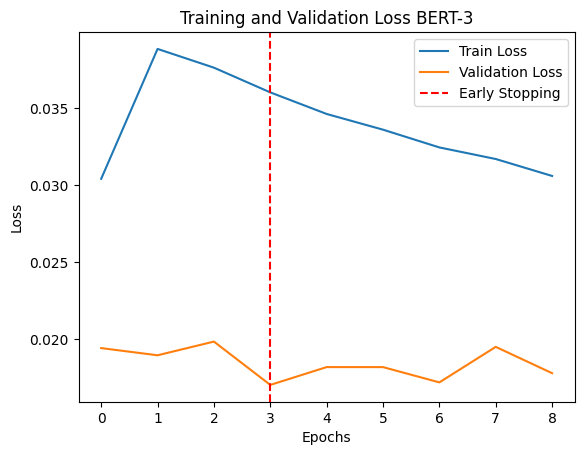

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [33]:
aple_targets, predictions = test(best_model, apl_test_BERT_data)

Mean Squared Error (MSE) on Test Set: 0.036415061155756226


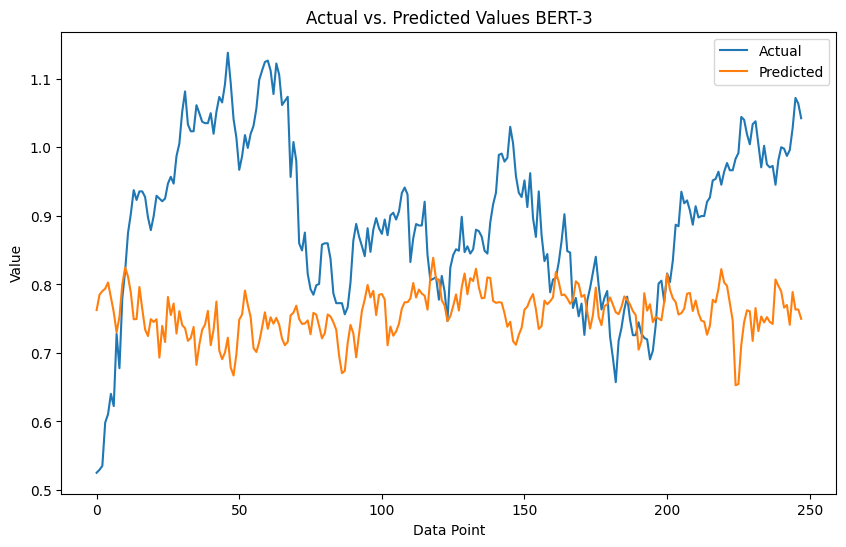

In [34]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [35]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_BERT_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.02899311089844281


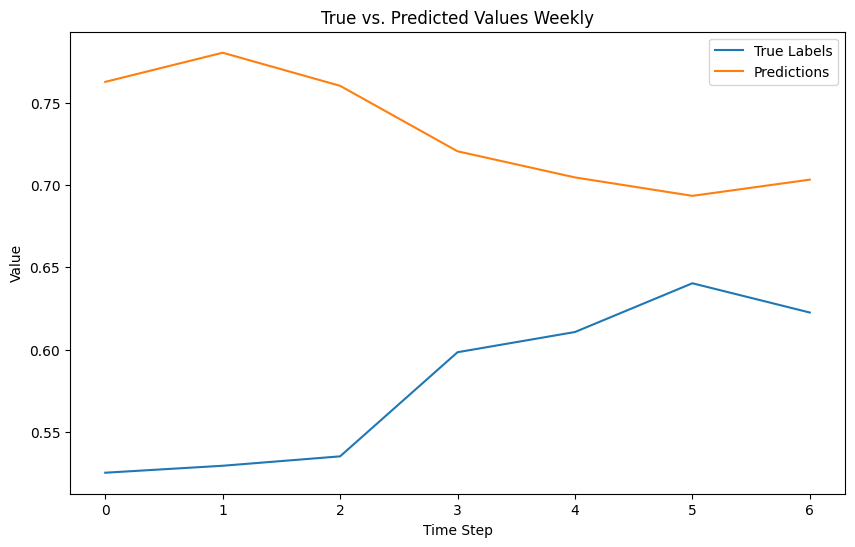

In [36]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:7], label="True Labels")
plt.plot(predictions[:7], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.04139060252587657


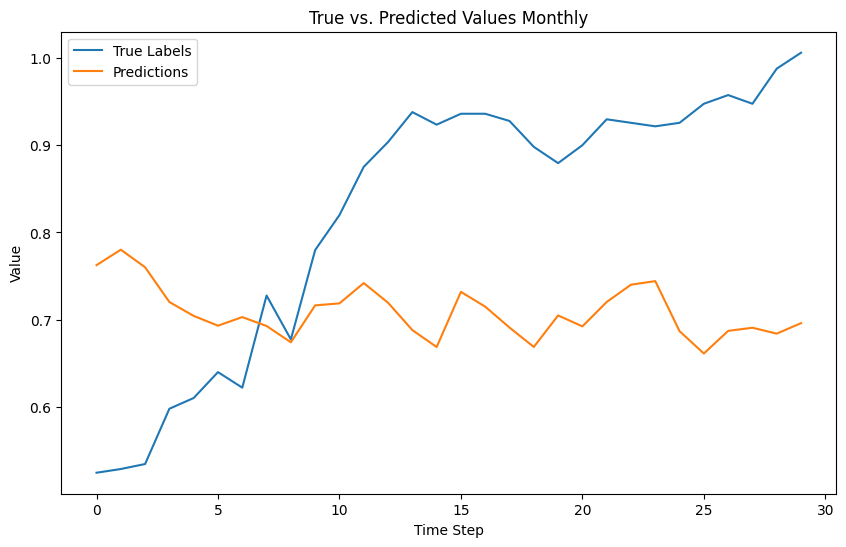

In [37]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 7

In [38]:
window_size = 7
MODEL_NAME = f"BERT-{window_size}"

In [39]:
train_BERT_data = create_bert_ready_data(train_data, companies, window_size)
val_BERT_data = create_bert_ready_data(val_data, companies, window_size)
apl_test_BERT_data = create_bert_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_BERT_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_BERT_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_BERT_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_bert_input(train_sequences)
val_encoded = encode_bert_input(val_sequences)
aple_encoded = encode_bert_input(aple_sequences)

In [40]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_BERT_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_BERT_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [41]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

1.04 Min for Training
0.1 Min for Validation
Epoch 1/15
  Train Loss: 0.0295
  Validation Loss: 0.0195
1.13 Min for Training
0.1 Min for Validation
Epoch 2/15
  Train Loss: 0.0358
  Validation Loss: 0.0176
1.13 Min for Training
0.1 Min for Validation
Epoch 3/15
  Train Loss: 0.0344
  Validation Loss: 0.0185
1.13 Min for Training
0.1 Min for Validation
Epoch 4/15
  Train Loss: 0.0324
  Validation Loss: 0.0177
1.13 Min for Training
0.1 Min for Validation
Epoch 5/15
  Train Loss: 0.0313
  Validation Loss: 0.0184
1.13 Min for Training
0.1 Min for Validation
Epoch 6/15
  Train Loss: 0.0308
  Validation Loss: 0.0177
1.13 Min for Training
0.1 Min for Validation
Epoch 7/15
  Train Loss: 0.0293
  Validation Loss: 0.0186
Early stopping at epoch 7 due to no improvement in validation loss.


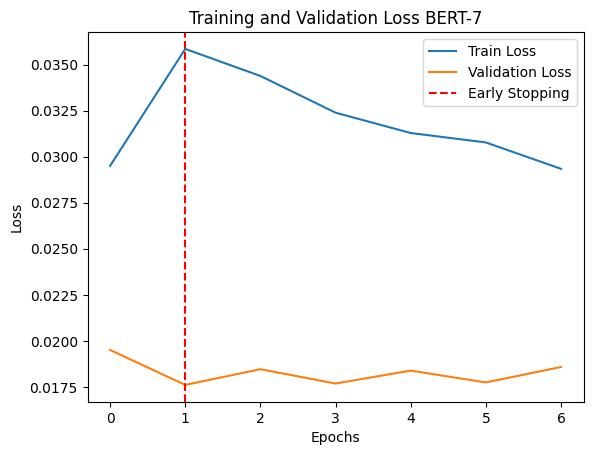

In [42]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [43]:
aple_targets, predictions = test(best_model, apl_test_BERT_data)

Mean Squared Error (MSE) on Test Set: 0.03657528178199438


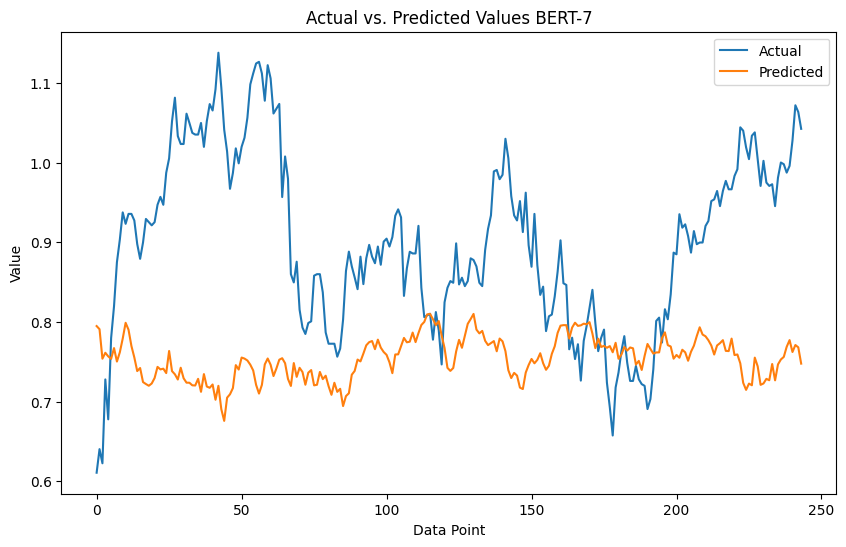

In [44]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [45]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_BERT_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.011398034917150886


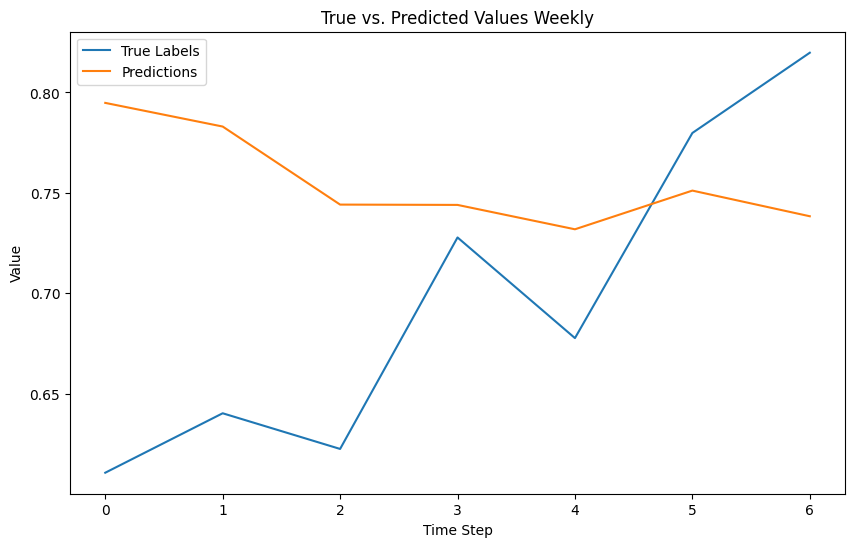

In [46]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:7], label="True Labels")
plt.plot(predictions[:7], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.04205139750859064


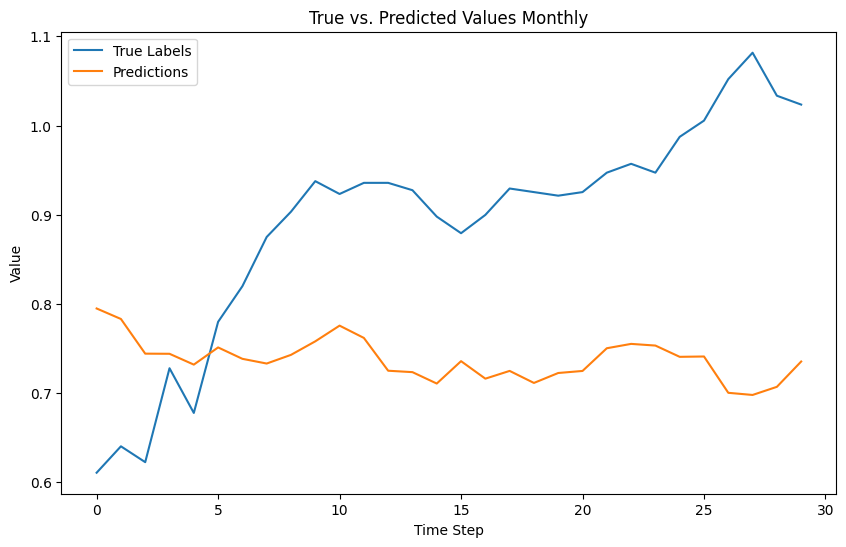

In [47]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 15

In [48]:
window_size = 15
MODEL_NAME = f"BERT-{window_size}"

In [49]:
train_BERT_data = create_bert_ready_data(train_data, companies, window_size)
val_BERT_data = create_bert_ready_data(val_data, companies, window_size)
apl_test_BERT_data = create_bert_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_BERT_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_BERT_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_BERT_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_bert_input(train_sequences)
val_encoded = encode_bert_input(val_sequences)
aple_encoded = encode_bert_input(aple_sequences)

In [50]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_BERT_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_BERT_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [51]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

2.14 Min for Training
0.2 Min for Validation
Epoch 1/15
  Train Loss: 0.0336
  Validation Loss: 0.0251
2.33 Min for Training
0.2 Min for Validation
Epoch 2/15
  Train Loss: 0.0386
  Validation Loss: 0.0218
2.33 Min for Training
0.2 Min for Validation
Epoch 3/15
  Train Loss: 0.0374
  Validation Loss: 0.0244
2.33 Min for Training
0.2 Min for Validation
Epoch 4/15
  Train Loss: 0.0354
  Validation Loss: 0.0254
2.33 Min for Training
0.2 Min for Validation
Epoch 5/15
  Train Loss: 0.0333
  Validation Loss: 0.0256
2.33 Min for Training
0.2 Min for Validation
Epoch 6/15
  Train Loss: 0.0318
  Validation Loss: 0.0233
2.33 Min for Training
0.2 Min for Validation
Epoch 7/15
  Train Loss: 0.0309
  Validation Loss: 0.0246
Early stopping at epoch 7 due to no improvement in validation loss.


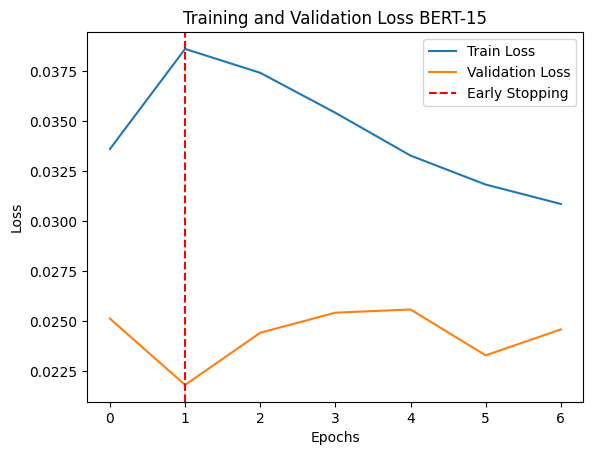

In [52]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [53]:
aple_targets, predictions = test(best_model, apl_test_BERT_data)

Mean Squared Error (MSE) on Test Set: 0.04548672802101151


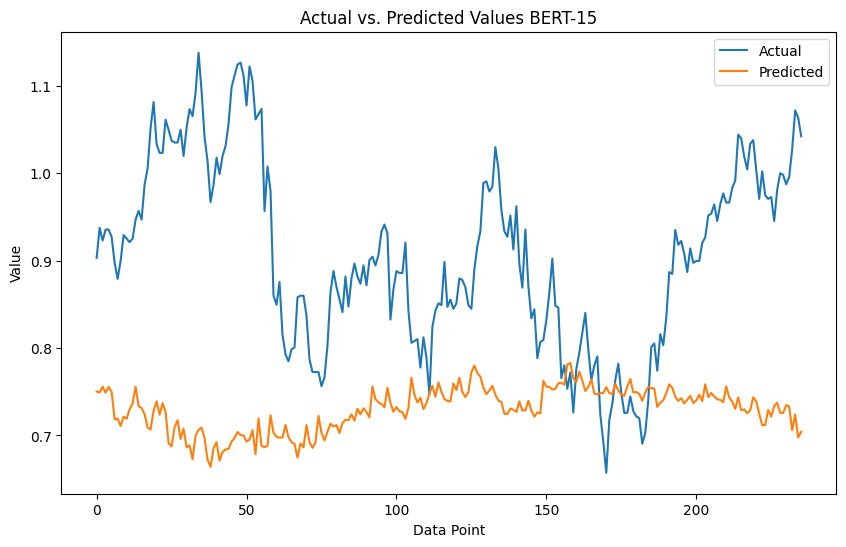

In [54]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [55]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_BERT_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.03338365288900145


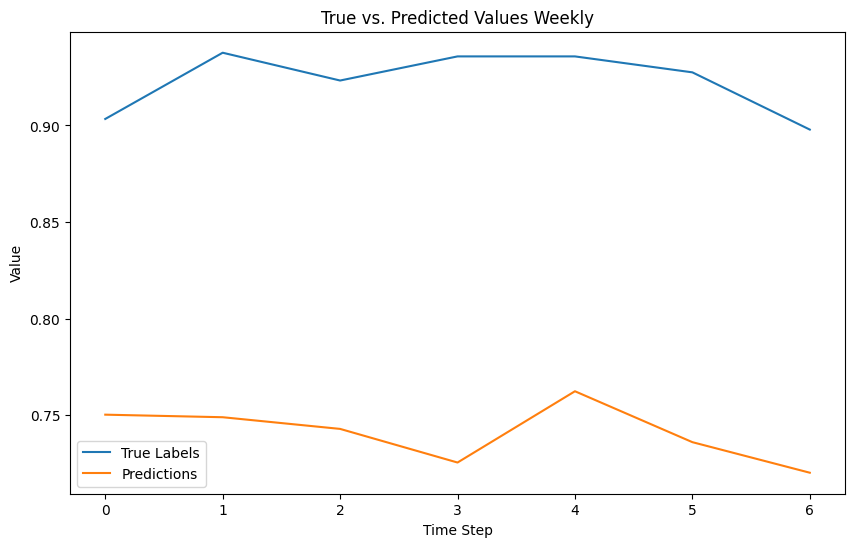

In [56]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:7], label="True Labels")
plt.plot(predictions[:7], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.07105013187183501


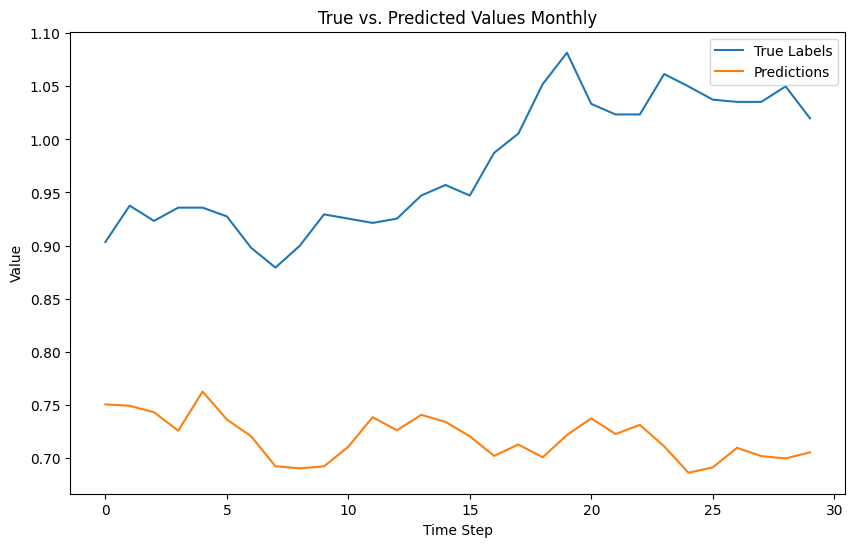

In [57]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 30

In [58]:
window_size = 30
MODEL_NAME = f"BERT-{window_size}"

In [59]:
train_BERT_data = create_bert_ready_data(train_data, companies, window_size)
val_BERT_data = create_bert_ready_data(val_data, companies, window_size)
apl_test_BERT_data = create_bert_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_BERT_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_BERT_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_BERT_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_bert_input(train_sequences)
val_encoded = encode_bert_input(val_sequences)
aple_encoded = encode_bert_input(aple_sequences)

In [60]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_BERT_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_BERT_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [61]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

3.98 Min for Training
0.35 Min for Validation
Epoch 1/15
  Train Loss: 0.0351
  Validation Loss: 0.0286
4.33 Min for Training
0.36 Min for Validation
Epoch 2/15
  Train Loss: 0.0418
  Validation Loss: 0.0270
4.33 Min for Training
0.35 Min for Validation
Epoch 3/15
  Train Loss: 0.0386
  Validation Loss: 0.0274
4.33 Min for Training
0.36 Min for Validation
Epoch 4/15
  Train Loss: 0.0371
  Validation Loss: 0.0300
4.33 Min for Training
0.36 Min for Validation
Epoch 5/15
  Train Loss: 0.0344
  Validation Loss: 0.0292
4.33 Min for Training
0.36 Min for Validation
Epoch 6/15
  Train Loss: 0.0330
  Validation Loss: 0.0301
4.33 Min for Training
0.36 Min for Validation
Epoch 7/15
  Train Loss: 0.0319
  Validation Loss: 0.0309
Early stopping at epoch 7 due to no improvement in validation loss.


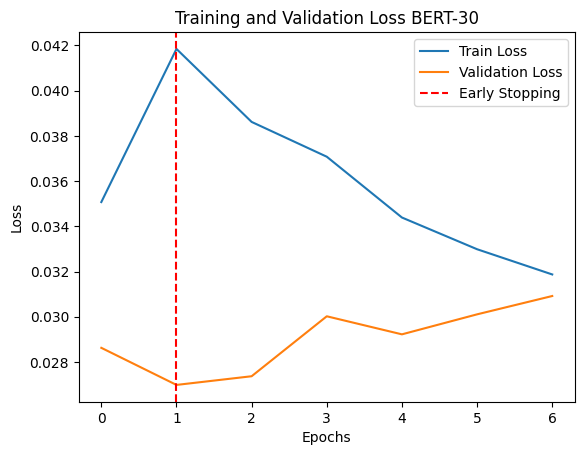

In [62]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [63]:
aple_targets, predictions = test(best_model, apl_test_BERT_data)

Mean Squared Error (MSE) on Test Set: 0.054771728216696534


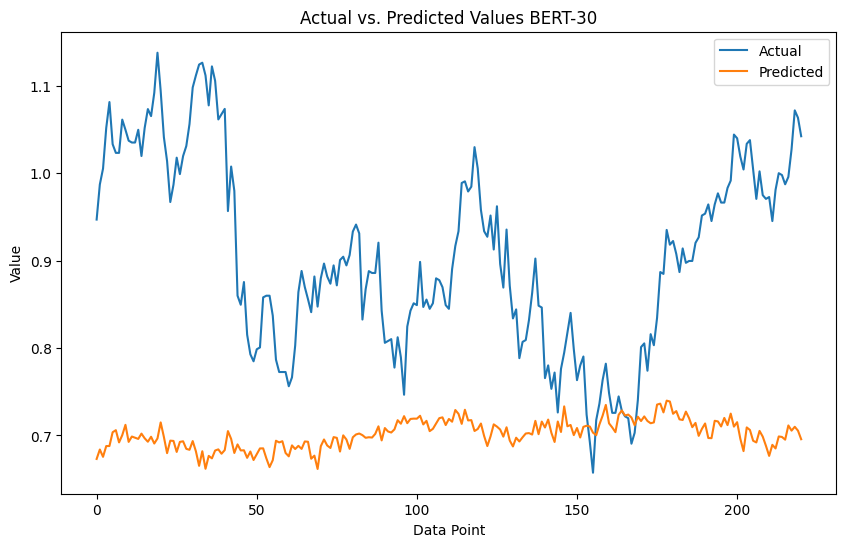

In [64]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [65]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_BERT_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.1098450927970982


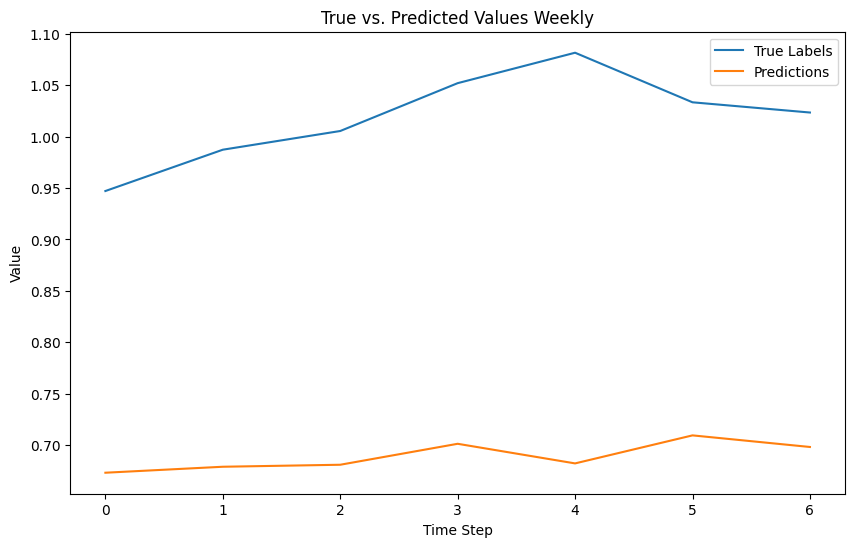

In [66]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:7], label="True Labels")
plt.plot(predictions[:7], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.11983902154604865


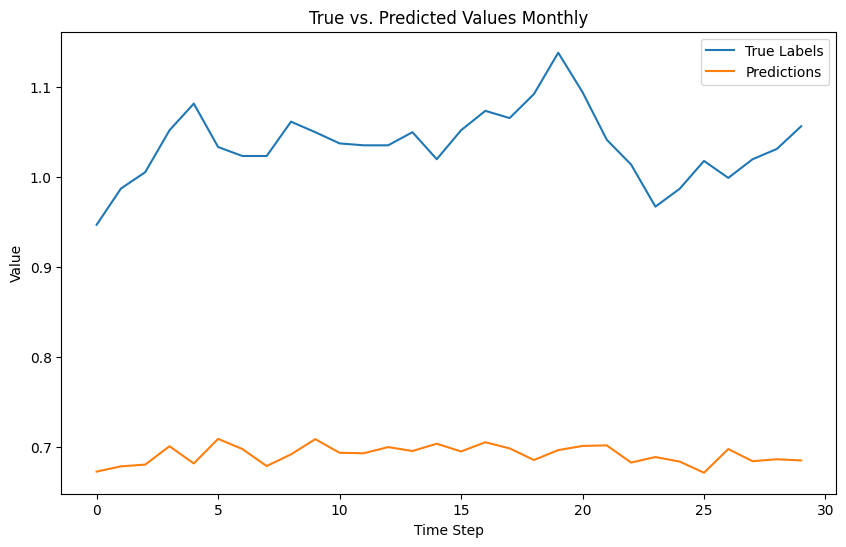

In [67]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 90

In [68]:
window_size = 90
MODEL_NAME = f"BERT-{window_size}"

In [69]:
train_BERT_data = create_bert_ready_data(train_data, companies, window_size)
val_BERT_data = create_bert_ready_data(val_data, companies, window_size)
apl_test_BERT_data = create_bert_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_BERT_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_BERT_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_BERT_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_bert_input(train_sequences)
val_encoded = encode_bert_input(val_sequences)
aple_encoded = encode_bert_input(aple_sequences)

In [70]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_BERT_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_BERT_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [71]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

3.89 Min for Training
0.28 Min for Validation
Epoch 1/15
  Train Loss: 0.0307
  Validation Loss: 0.0134
4.16 Min for Training
0.28 Min for Validation
Epoch 2/15
  Train Loss: 0.0401
  Validation Loss: 0.0162
4.16 Min for Training
0.28 Min for Validation
Epoch 3/15
  Train Loss: 0.0387
  Validation Loss: 0.0166
4.16 Min for Training
0.28 Min for Validation
Epoch 4/15
  Train Loss: 0.0375
  Validation Loss: 0.0197
4.16 Min for Training
0.28 Min for Validation
Epoch 5/15
  Train Loss: 0.0353
  Validation Loss: 0.0220
4.16 Min for Training
0.28 Min for Validation
Epoch 6/15
  Train Loss: 0.0345
  Validation Loss: 0.0205
Early stopping at epoch 6 due to no improvement in validation loss.


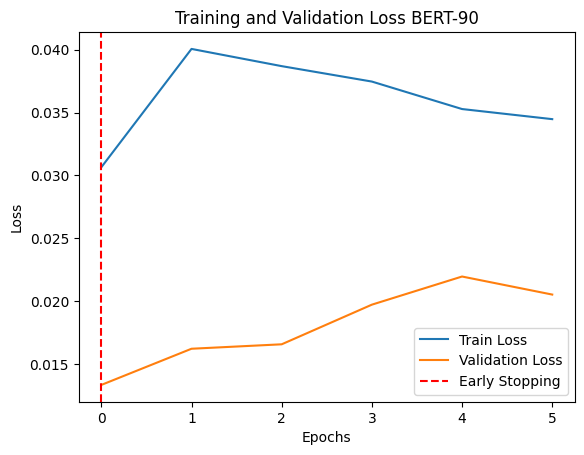

In [72]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [73]:
aple_targets, predictions = test(best_model, apl_test_BERT_data)

Mean Squared Error (MSE) on Test Set: 0.016974738521745133


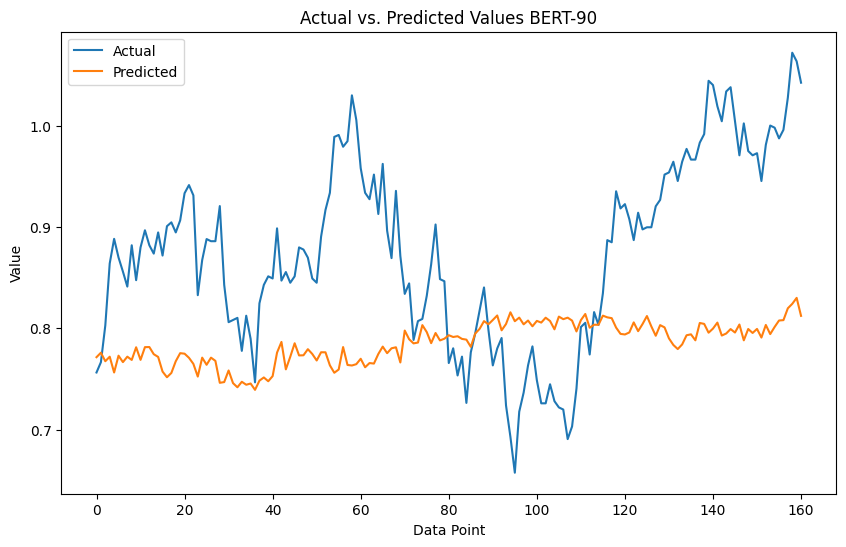

In [74]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [75]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_BERT_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.006076125711283563


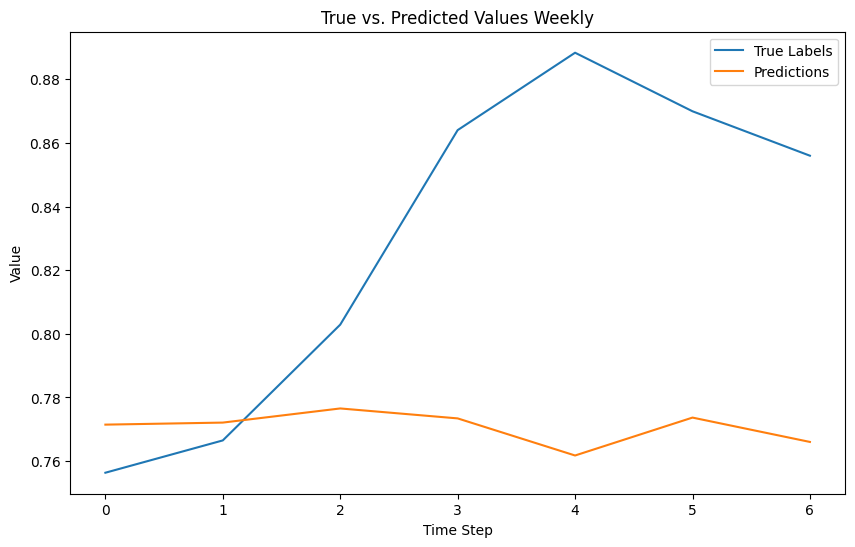

In [76]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:7], label="True Labels")
plt.plot(predictions[:7], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.013240171309737219


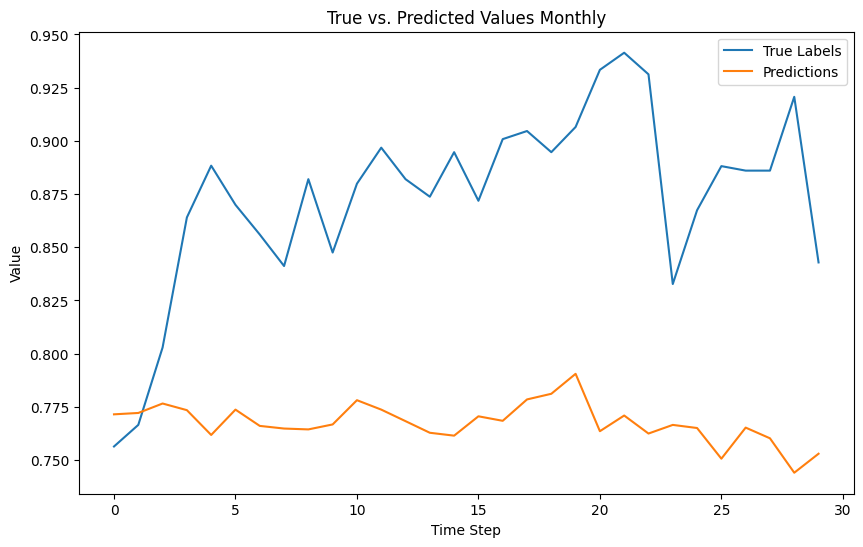

In [77]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

# RoBERTa

In [78]:
import pandas as pd

def prepare_roberta_input_for_company(df, window_size, target_col="Close", precision=6, max_sequence_length=512):
    """
    Prepares the RoBERTa input for a single company's data by filtering, sorting by date, and creating sequences.

    Args:
    - df: The company's DataFrame containing historical stock data (filtered by company).
    - window_size: The size of the window for the sequence.
    - target_col: The column to predict (default is "Close").
    - precision: The number of decimal places to round the input features (default is 4).
    - max_sequence_length: The maximum sequence length (default is 512, typical for BERT).

    Returns:
    - A list of input sequences ready for BERT.
    """
    # Sort the data by date
    df = df.sort_values(by="Date")

    # Create sequences for the BERT input
    sequences = []
    for i in range(len(df) - window_size):
        # Create a sequence window based on the input features
        input_data = df.iloc[i:i + window_size][["Close", "MACD_Line", "RSI"]].values
        target = df.iloc[i + window_size][target_col]

        # Round the input data to the specified precision
        input_data = [[round(val, precision) for val in row] for row in input_data]

        # Format the input data in a way suitable for BERT
        input_sequence = "[CLS] "  # BERT start token
        for data_point in input_data:
            input_sequence += " ".join(map(str, data_point)) + " [SEP] "

        input_sequence = input_sequence.strip()  # Remove extra trailing separator

        # Ensure the sequence doesn't exceed the max_sequence_length
        if len(input_sequence.split()) > max_sequence_length:
            input_sequence = " ".join(input_sequence.split()[:max_sequence_length])

        # Append the sequence and target as a tuple
        sequences.append((input_sequence, target))

    return sequences

def create_roberta_ready_data(df, companies, window_size=5):
    """
    Creates the BERT-ready input data for all companies.

    Args:
    - df: The DataFrame containing stock data for all companies.
    - companies: List of companies to create sequences for.
    - window_size: The size of the time window for the sequence (default is 5).

    Returns:
    - A list of tuples containing the sequences and targets for all companies.
    """
    all_sequences = []

    for company in companies:
        company_data = df[df["company_name"] == company]

        # Prepare BERT input for this company
        company_sequences = prepare_roberta_input_for_company(company_data, window_size)

        # Append sequences for the current company
        all_sequences.extend(company_sequences)

    return all_sequences

In [79]:
!pip install transformers

In [80]:
from transformers import RobertaTokenizer, RobertaModel

In [81]:
# Initialize the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_roberta_input(sequences, max_length=512):
    """
    Encodes a list of input sequences using BERT tokenizer.

    Args:
    - sequences: A list of input sequences in string format.
    - max_length: Maximum length of the tokenized sequence. Default is 512.

    Returns:
    - encoded_inputs: A dictionary containing the input IDs, attention masks, and token type IDs for BERT.
    """
    # Tokenize the sequences using RoBERT tokenizer
    encoded_inputs = tokenizer.batch_encode_plus(
        sequences,
        padding=True,  # Pad sequences to the same length
        truncation=True,  # Truncate sequences if they exceed max_length
        max_length=max_length,  # Set the max length of the tokenized sequences
        return_tensors="pt",  # Return PyTorch tensors
        return_attention_mask=True,  # Return attention masks
        return_token_type_ids=True  # Return token type IDs (useful for multi-segment input)
    )

    return encoded_inputs

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [82]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim

In [83]:
# Define model
class StockPredictionModel_RoBERTA(nn.Module):
    def __init__(self, roberta_model):
        super(StockPredictionModel_RoBERTA, self).__init__()
        self.roberta = roberta_model
        self.fc1 = nn.Linear(768, 256)
        self.dropout = nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(256, 1)

        # Freeze BERT layers
        for param in self.roberta.parameters():
            param.requires_grad = False


    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Disable gradient calculation for BERT
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_output)  # Apply dropout
        x = self.fc1(x)
        x = self.dropout(x)  # Apply dropout again if needed
        prediction = self.fc2(x)
        return prediction

# Initialize Bert model
roberta_model = RobertaModel.from_pretrained("roberta-base", add_pooling_layer=False)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [84]:
import time
from copy import deepcopy

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for training.")
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU for training.")

criterion = nn.MSELoss()
criterion.to(device)

def trainer(train_dataloader, val_dataloader, epochs = 16, patience = 5, lr=1e-5):
  # Move model and loss function to the device
  model = StockPredictionModel_RoBERTA(roberta_model)
  model.to(device)

  optimizer = optim.AdamW(model.parameters(), lr, weight_decay=1e-3)
  # Initialize lists to store losses
  train_losses = []
  val_losses = []

  # Patience mechanism parameters
  best_val_loss = float("inf")  # Initialize with a very large value
  epochs_without_improvement = 0

  st = time.time()
  best_model = None  # Store the best model during training
  # Training loop
  for epoch in range(epochs):
      # Training phase
      model.train()
      total_train_loss = 0
      for input_ids, attention_mask, labels in train_dataloader:
          # Move data to the device
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          predictions = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()
          loss = criterion(predictions, labels)
          loss.backward()
          optimizer.step()
          total_train_loss += loss.item()

      avg_train_loss = total_train_loss / len(train_dataloader)
      train_losses.append(avg_train_loss)
      print(f"{round((time.time() - st)/60, 2)} Min for Training")

      st = time.time()
      # Validation phase
      model.eval()

      total_val_loss = 0
      with torch.no_grad():
          for input_ids, attention_mask, labels in val_dataloader:
              # Move data to the device in the validation loop
              input_ids = input_ids.to(device)
              attention_mask = attention_mask.to(device)
              labels = labels.to(device)
              predictions = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()
              loss = criterion(predictions, labels)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(val_dataloader)
      val_losses.append(avg_val_loss)
      print(f"{round((time.time() - st)/60, 2)} Min for Validation")

      # Check for improvement and update patience counter
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          epochs_without_improvement = 0
          best_model = deepcopy(model)  # Save the model's state dictionary
      else:
          epochs_without_improvement += 1

      # Print epoch losses
      print(f"Epoch {epoch + 1}/{epochs}")
      print(f"  Train Loss: {avg_train_loss:.4f}")
      print(f"  Validation Loss: {avg_val_loss:.4f}")

      # Early stopping if no improvement for a certain number of epochs
      if epochs_without_improvement >= patience:
          print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
          break

  return best_model, train_losses, val_losses, epoch, epochs_without_improvement

Using CUDA for training.


In [85]:
def test(model, apl_test_RoBERTa_data):
  # Load the best model
  model.eval()

  aple_targets = [seq[1] for seq in apl_test_RoBERTa_data]  # Extract target values from aple_data
  aple_targets_ten = torch.tensor(aple_targets, dtype=torch.float32) # Convert to tensor
  aple_data_tensor_td = TensorDataset(aple_encoded["input_ids"], aple_encoded["attention_mask"], aple_targets_ten)  # Create TensorDataset
  aple_dataloader = DataLoader(aple_data_tensor_td, batch_size=32, shuffle=False)

  # Make predictions
  predictions = []
  with torch.no_grad():
      for input_ids, attention_mask, labels in aple_dataloader:  # Use aple_dataloader here
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          predictions.extend(outputs.cpu().numpy().flatten())

  # Evaluate the model
  mse = mean_squared_error(aple_targets, predictions)  # Use aple_targets here
  print(f"Mean Squared Error (MSE) on Test Set: {mse}")

  return aple_targets, predictions

In [86]:
companies = train_data["company_name"].unique()

In [87]:
def multi_step_prediction(model, org_data, tokenizer, device, window_size):
    """
    Performs multi-step prediction for time series data using a given model.

    Args:
        model: The trained model.
        org_data: The original input data as a list of lists.
        tokenizer: The tokenizer used for the model.
        device: The device to run the model on (e.g., "cuda" or "cpu").
        window_size: The size of the window for each prediction.

    Returns:
        A tuple containing:
            - The updated data with predicted values.
            - A list of predictions.
    """
    predictions = []
    true_lables = []
    data = org_data.copy()
    data = [list(item) for item in data]
    for i in range(len(data) - window_size):
        # Extract the current window
        input_data = data[i][0]
        true_prediction = data[i][1]
        true_lables.append(true_prediction)

        # Tokenize the window
        inputs = tokenizer(input_data, return_tensors="pt", padding=True, truncation=True)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Make prediction with single-step approach
        with torch.no_grad():
            prediction = model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = prediction.item()

        # Update the next 'window_size' instances
        for j in range(1, window_size + 1):
            index_to_update = (window_size - j) * window_size + 1 + (window_size - j) + 1
            # Split the existing instance into a list of strings
            old_instance = data[i + j][0].split(' ')

            # Replace the value at the calculated index with the prediction
            old_instance[index_to_update] = str(round(prediction, 4))

            # Join the updated list back into a string
            data[i + j][0] = ' '.join(old_instance)

        predictions.append(prediction)

    return true_lables, predictions

## Window Size 3

In [88]:
window_size = 3
MODEL_NAME = f"RoBERTa-{window_size}"

In [89]:
train_RoBERTA_data = create_roberta_ready_data(train_data, companies, window_size)
val_RoBERTA_data = create_roberta_ready_data(val_data, companies, window_size)
apl_test_RoBERTA_data = create_roberta_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_RoBERTA_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_RoBERTA_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_RoBERTA_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_roberta_input(train_sequences)
val_encoded = encode_roberta_input(val_sequences)
aple_encoded = encode_roberta_input(aple_sequences)

In [90]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_RoBERTA_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_RoBERTA_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [91]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

0.51 Min for Training
0.04 Min for Validation
Epoch 1/16
  Train Loss: 0.0469
  Validation Loss: 0.2080
0.56 Min for Training
0.04 Min for Validation
Epoch 2/16
  Train Loss: 0.0516
  Validation Loss: 0.2048
0.56 Min for Training
0.04 Min for Validation
Epoch 3/16
  Train Loss: 0.0498
  Validation Loss: 0.1967
0.56 Min for Training
0.04 Min for Validation
Epoch 4/16
  Train Loss: 0.0492
  Validation Loss: 0.1960
0.56 Min for Training
0.04 Min for Validation
Epoch 5/16
  Train Loss: 0.0484
  Validation Loss: 0.1917
0.56 Min for Training
0.04 Min for Validation
Epoch 6/16
  Train Loss: 0.0484
  Validation Loss: 0.1928
0.56 Min for Training
0.04 Min for Validation
Epoch 7/16
  Train Loss: 0.0472
  Validation Loss: 0.1889
0.56 Min for Training
0.04 Min for Validation
Epoch 8/16
  Train Loss: 0.0463
  Validation Loss: 0.1868
0.56 Min for Training
0.04 Min for Validation
Epoch 9/16
  Train Loss: 0.0466
  Validation Loss: 0.1914
0.56 Min for Training
0.04 Min for Validation
Epoch 10/16
  Trai

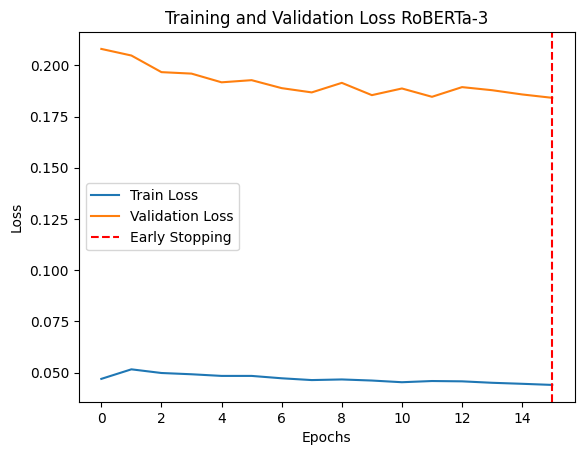

In [92]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [93]:
aple_targets, predictions = test(best_model, apl_test_RoBERTA_data)

Mean Squared Error (MSE) on Test Set: 0.2607746286827586


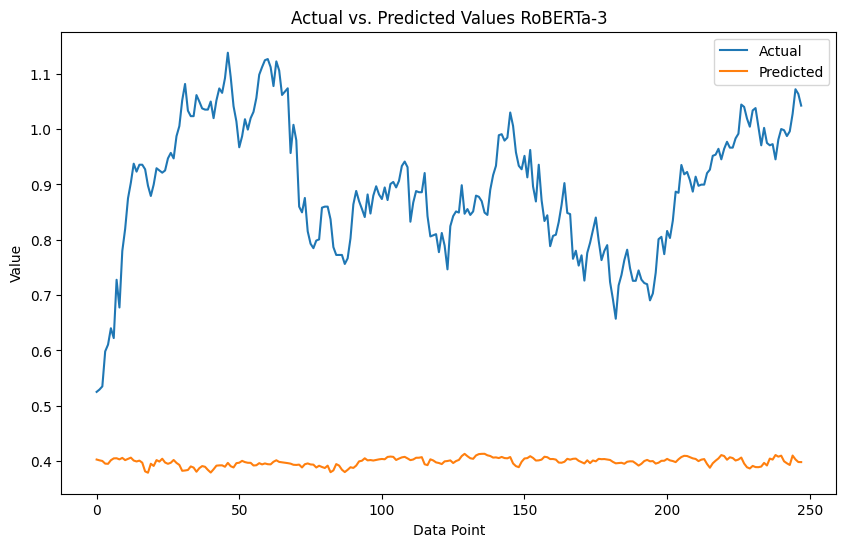

In [94]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [95]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_RoBERTA_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.03608995341583115


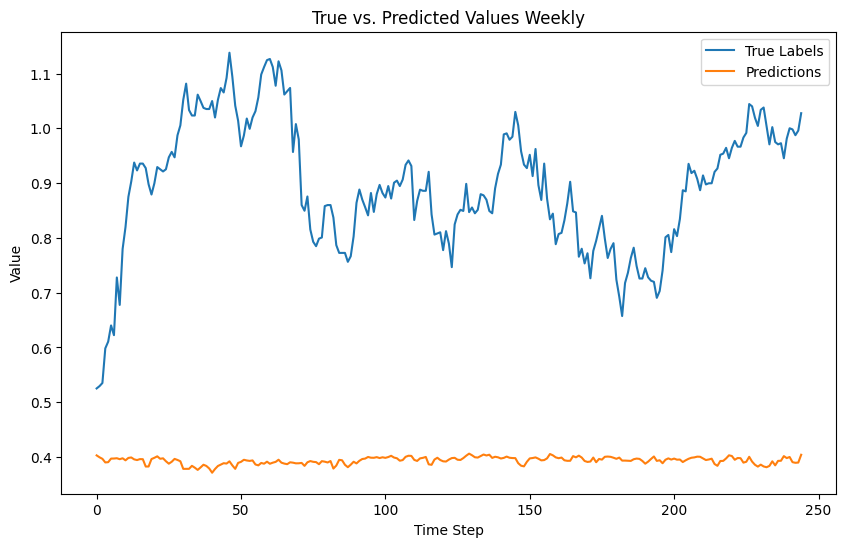

In [96]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables, label="True Labels")
plt.plot(predictions, label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.2077438453852216


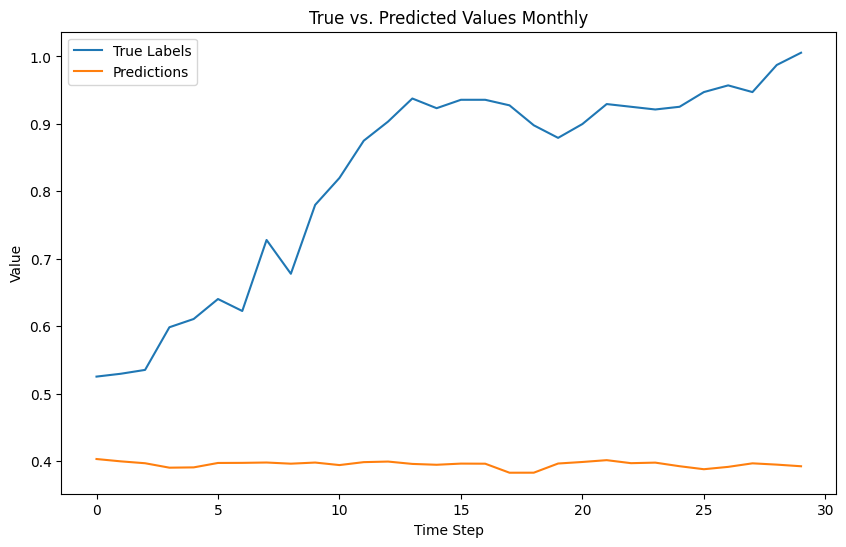

In [97]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 7

In [98]:
window_size = 7
MODEL_NAME = f"RoBERTa-{window_size}"

In [99]:
train_RoBERTA_data = create_roberta_ready_data(train_data, companies, window_size)
val_RoBERTA_data = create_roberta_ready_data(val_data, companies, window_size)
apl_test_RoBERTA_data = create_roberta_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_RoBERTA_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_RoBERTA_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_RoBERTA_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_roberta_input(train_sequences)
val_encoded = encode_roberta_input(val_sequences)
aple_encoded = encode_roberta_input(aple_sequences)

In [100]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_RoBERTA_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_RoBERTA_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [101]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

1.02 Min for Training
0.1 Min for Validation
Epoch 1/16
  Train Loss: 0.0640
  Validation Loss: 0.2310
1.13 Min for Training
0.1 Min for Validation
Epoch 2/16
  Train Loss: 0.0550
  Validation Loss: 0.2157
1.13 Min for Training
0.1 Min for Validation
Epoch 3/16
  Train Loss: 0.0506
  Validation Loss: 0.2052
1.13 Min for Training
0.1 Min for Validation
Epoch 4/16
  Train Loss: 0.0486
  Validation Loss: 0.2015
1.13 Min for Training
0.1 Min for Validation
Epoch 5/16
  Train Loss: 0.0472
  Validation Loss: 0.1982
1.13 Min for Training
0.1 Min for Validation
Epoch 6/16
  Train Loss: 0.0466
  Validation Loss: 0.1934
1.13 Min for Training
0.1 Min for Validation
Epoch 7/16
  Train Loss: 0.0453
  Validation Loss: 0.1907
1.13 Min for Training
0.1 Min for Validation
Epoch 8/16
  Train Loss: 0.0449
  Validation Loss: 0.1953
1.13 Min for Training
0.1 Min for Validation
Epoch 9/16
  Train Loss: 0.0440
  Validation Loss: 0.1889
1.13 Min for Training
0.1 Min for Validation
Epoch 10/16
  Train Loss: 0.

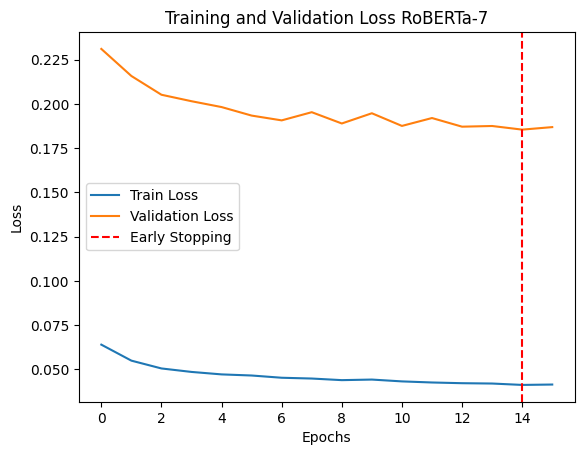

In [102]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [103]:
aple_targets, predictions = test(best_model, apl_test_RoBERTA_data)

Mean Squared Error (MSE) on Test Set: 0.265380939821984


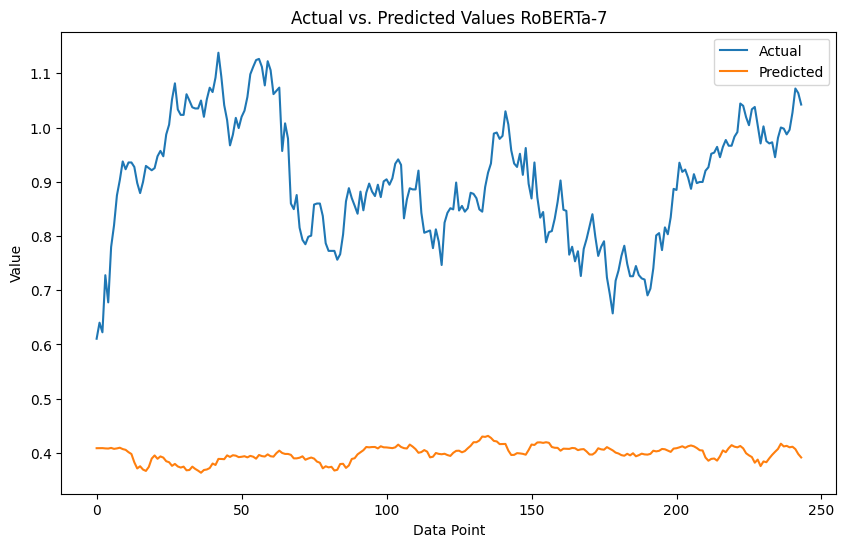

In [104]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [105]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_RoBERTA_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.08936472522250871


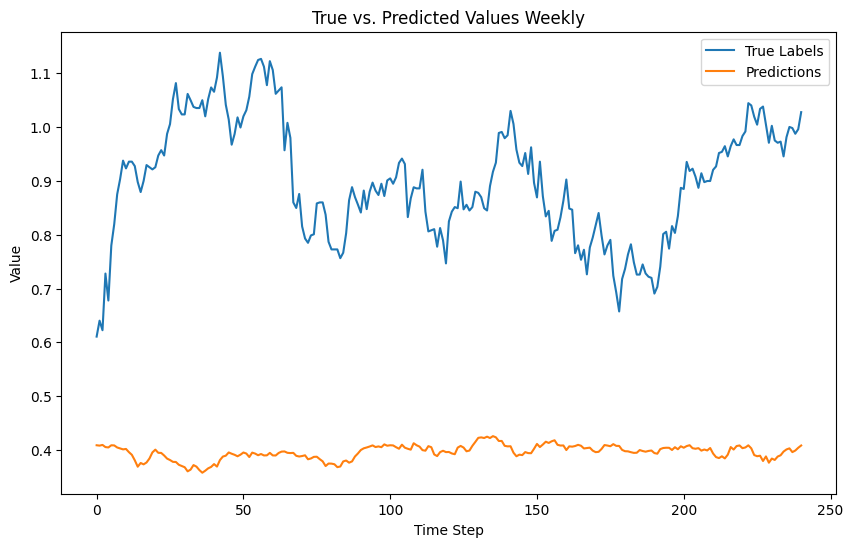

In [106]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables, label="True Labels")
plt.plot(predictions, label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.2668220834303252


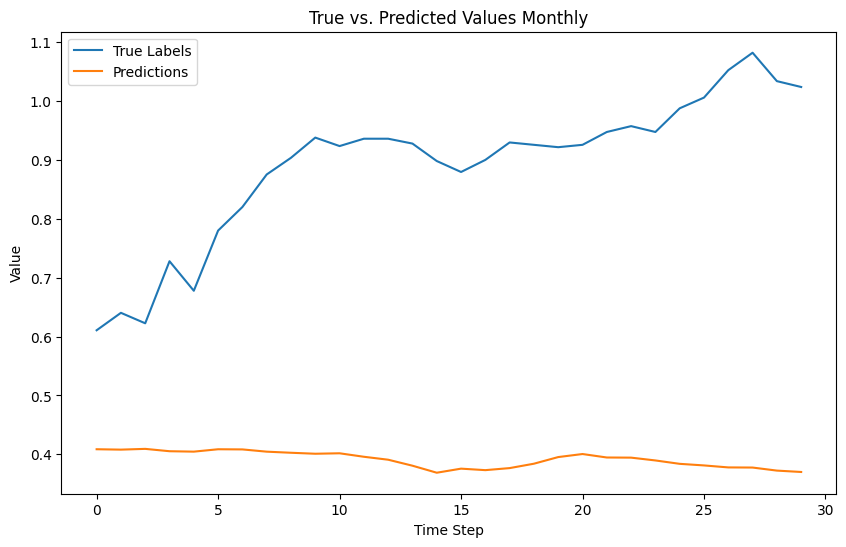

In [107]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 15

In [108]:
window_size = 15
MODEL_NAME = f"RoBERTa-{window_size}"

In [109]:
train_RoBERTA_data = create_roberta_ready_data(train_data, companies, window_size)
val_RoBERTA_data = create_roberta_ready_data(val_data, companies, window_size)
apl_test_RoBERTA_data = create_roberta_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_RoBERTA_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_RoBERTA_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_RoBERTA_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_roberta_input(train_sequences)
val_encoded = encode_roberta_input(val_sequences)
aple_encoded = encode_roberta_input(aple_sequences)

In [110]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_RoBERTA_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_RoBERTA_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [111]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

2.14 Min for Training
0.2 Min for Validation
Epoch 1/16
  Train Loss: 0.0555
  Validation Loss: 0.2126
2.35 Min for Training
0.2 Min for Validation
Epoch 2/16
  Train Loss: 0.0539
  Validation Loss: 0.2042
2.35 Min for Training
0.2 Min for Validation
Epoch 3/16
  Train Loss: 0.0506
  Validation Loss: 0.2019
2.35 Min for Training
0.2 Min for Validation
Epoch 4/16
  Train Loss: 0.0474
  Validation Loss: 0.1978
2.35 Min for Training
0.2 Min for Validation
Epoch 5/16
  Train Loss: 0.0465
  Validation Loss: 0.1898
2.34 Min for Training
0.2 Min for Validation
Epoch 6/16
  Train Loss: 0.0451
  Validation Loss: 0.1875
2.34 Min for Training
0.2 Min for Validation
Epoch 7/16
  Train Loss: 0.0450
  Validation Loss: 0.1887
2.34 Min for Training
0.2 Min for Validation
Epoch 8/16
  Train Loss: 0.0425
  Validation Loss: 0.1874
2.35 Min for Training
0.2 Min for Validation
Epoch 9/16
  Train Loss: 0.0423
  Validation Loss: 0.1864
2.34 Min for Training
0.2 Min for Validation
Epoch 10/16
  Train Loss: 0.

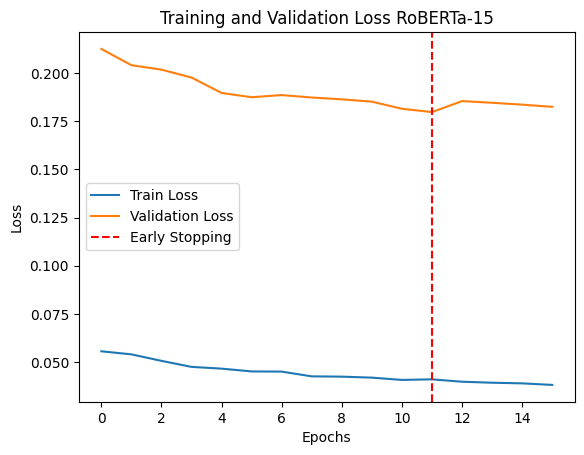

In [112]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [113]:
aple_targets, predictions = test(best_model, apl_test_RoBERTA_data)

Mean Squared Error (MSE) on Test Set: 0.26473793158571


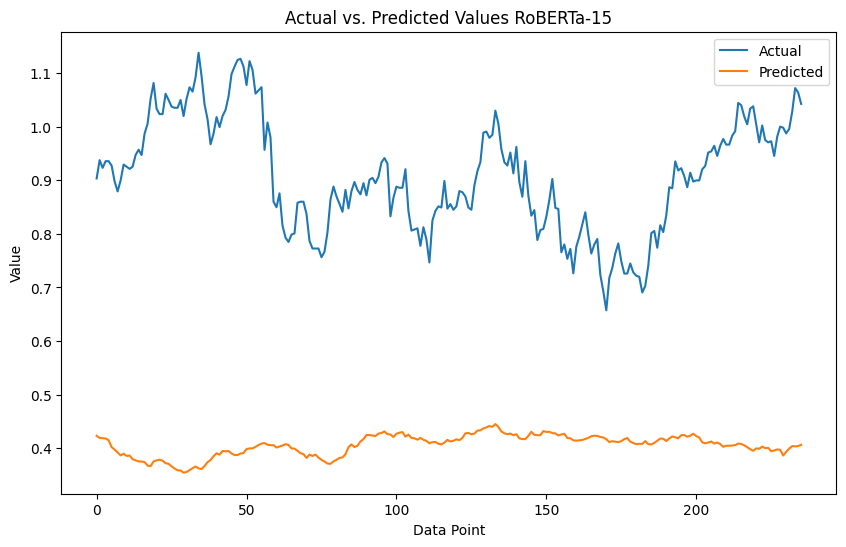

In [114]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [115]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_RoBERTA_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.25895499350776463


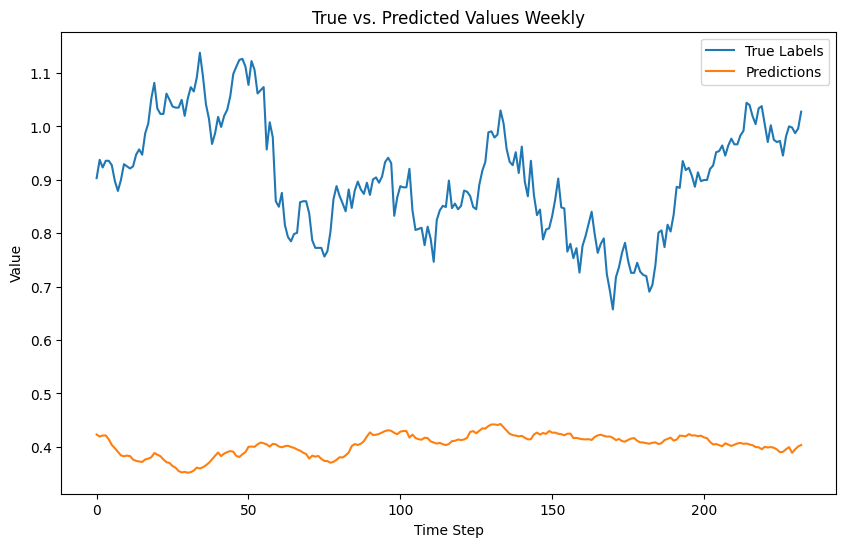

In [116]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables, label="True Labels")
plt.plot(predictions, label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.35646383477083304


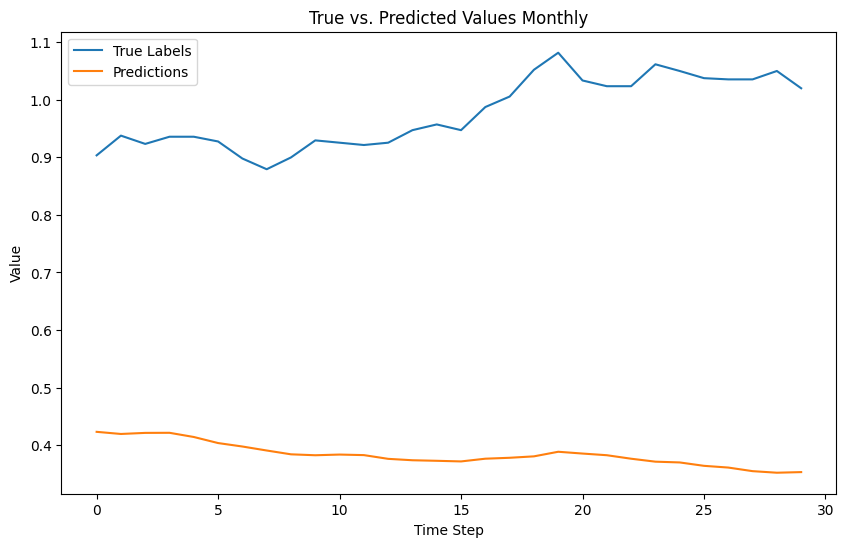

In [117]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 30

In [118]:
window_size = 30
MODEL_NAME = f"RoBERTa-{window_size}"

In [119]:
train_RoBERTA_data = create_roberta_ready_data(train_data, companies, window_size)
val_RoBERTA_data = create_roberta_ready_data(val_data, companies, window_size)
apl_test_RoBERTA_data = create_roberta_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_RoBERTA_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_RoBERTA_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_RoBERTA_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_roberta_input(train_sequences)
val_encoded = encode_roberta_input(val_sequences)
aple_encoded = encode_roberta_input(aple_sequences)

In [120]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_RoBERTA_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_RoBERTA_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [121]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

3.94 Min for Training
0.35 Min for Validation
Epoch 1/16
  Train Loss: 0.0529
  Validation Loss: 0.2115
4.29 Min for Training
0.35 Min for Validation
Epoch 2/16
  Train Loss: 0.0536
  Validation Loss: 0.2097
4.29 Min for Training
0.35 Min for Validation
Epoch 3/16
  Train Loss: 0.0503
  Validation Loss: 0.2032
4.29 Min for Training
0.35 Min for Validation
Epoch 4/16
  Train Loss: 0.0471
  Validation Loss: 0.1986
4.29 Min for Training
0.35 Min for Validation
Epoch 5/16
  Train Loss: 0.0461
  Validation Loss: 0.1986
4.29 Min for Training
0.35 Min for Validation
Epoch 6/16
  Train Loss: 0.0431
  Validation Loss: 0.1915
4.29 Min for Training
0.35 Min for Validation
Epoch 7/16
  Train Loss: 0.0430
  Validation Loss: 0.1919
4.29 Min for Training
0.35 Min for Validation
Epoch 8/16
  Train Loss: 0.0420
  Validation Loss: 0.1947
4.29 Min for Training
0.35 Min for Validation
Epoch 9/16
  Train Loss: 0.0402
  Validation Loss: 0.1891
4.29 Min for Training
0.35 Min for Validation
Epoch 10/16
  Trai

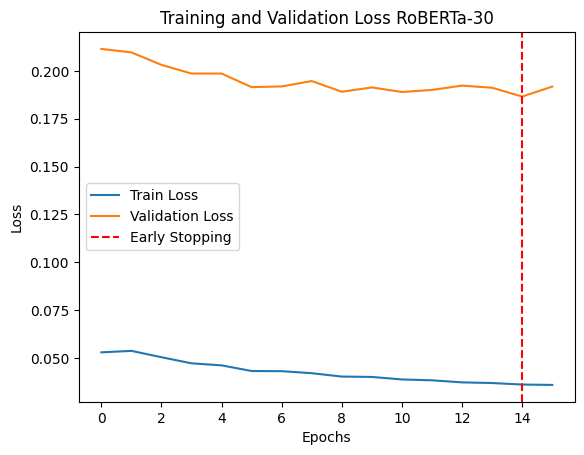

In [122]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [123]:
aple_targets, predictions = test(best_model, apl_test_RoBERTA_data)

Mean Squared Error (MSE) on Test Set: 0.2671743042135156


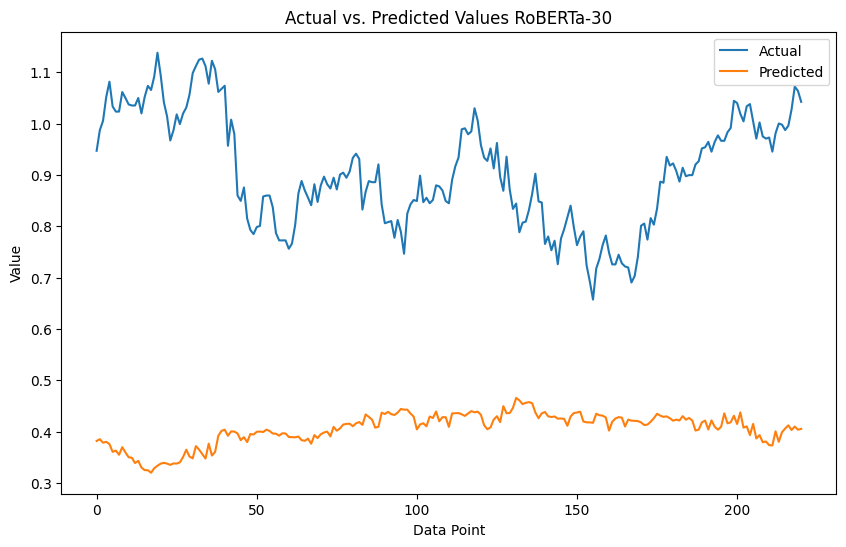

In [124]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [125]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_RoBERTA_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.412839926133547


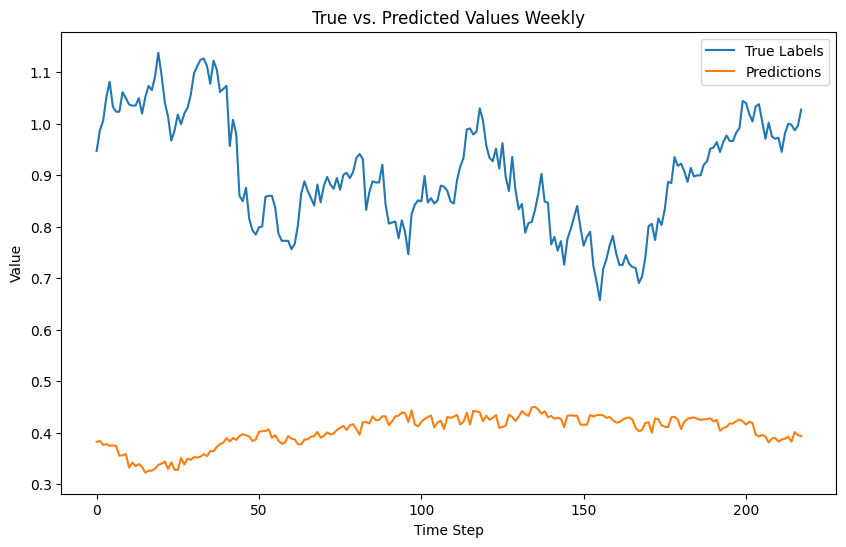

In [126]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables, label="True Labels")
plt.plot(predictions, label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.4767436456221772


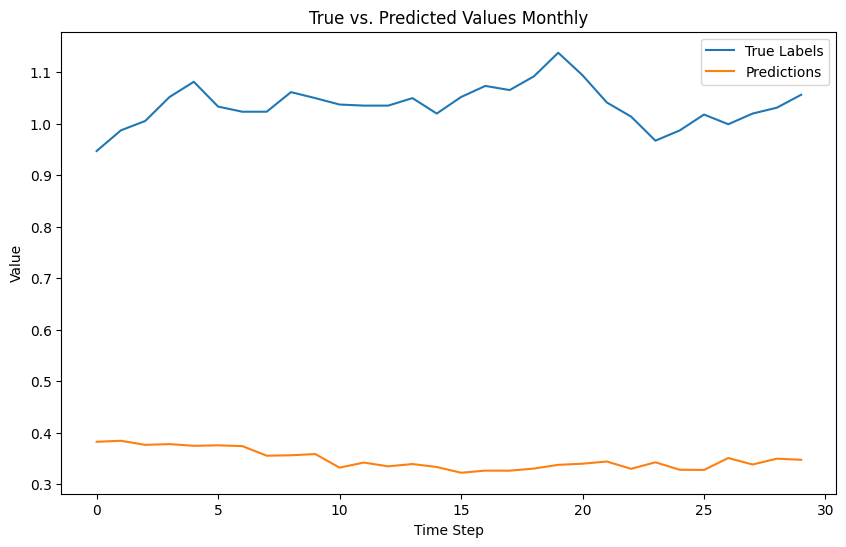

In [127]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

## Window Size 90

In [128]:
window_size = 90
MODEL_NAME = f"RoBERTa-{window_size}"

In [129]:
train_RoBERTA_data = create_roberta_ready_data(train_data, companies, window_size)
val_RoBERTA_data = create_roberta_ready_data(val_data, companies, window_size)
apl_test_RoBERTA_data = create_roberta_ready_data(aple_test, companies, window_size)

train_sequences = [seq[0] for seq in train_RoBERTA_data]  # Extract the input sequences from train data
val_sequences = [seq[0] for seq in val_RoBERTA_data]  # Extract the input sequences from val data
aple_sequences = [seq[0] for seq in apl_test_RoBERTA_data]  # Extract the input sequences from aple test data

# Encode the sequences
train_encoded = encode_roberta_input(train_sequences)
val_encoded = encode_roberta_input(val_sequences)
aple_encoded = encode_roberta_input(aple_sequences)

In [130]:
from torch.utils.data import DataLoader, TensorDataset

train_targets = [seq[1] for seq in train_RoBERTA_data]  # Extract target values from train_data
train_targets_ten = torch.tensor(train_targets, dtype=torch.float32) # Convert to tensor
train_data_tensor_td = TensorDataset(train_encoded["input_ids"], train_encoded["attention_mask"], train_targets_ten)  # Create TensorDataset
train_dataloader = DataLoader(train_data_tensor_td, batch_size=32, shuffle=False)

val_targets = [seq[1] for seq in val_RoBERTA_data]  # Extract target values from val_data
val_targets_ten = torch.tensor(val_targets, dtype=torch.float32) # Convert to tensor
val_data_tensor_td = TensorDataset(val_encoded["input_ids"], val_encoded["attention_mask"], val_targets_ten)  # Create TensorDataset
val_dataloader = DataLoader(val_data_tensor_td, batch_size=32, shuffle=False)

In [131]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trainer(train_dataloader, val_dataloader)

3.86 Min for Training
0.28 Min for Validation
Epoch 1/16
  Train Loss: 0.0553
  Validation Loss: 0.2428
4.14 Min for Training
0.28 Min for Validation
Epoch 2/16
  Train Loss: 0.0547
  Validation Loss: 0.2340
4.14 Min for Training
0.28 Min for Validation
Epoch 3/16
  Train Loss: 0.0503
  Validation Loss: 0.2308
4.14 Min for Training
0.28 Min for Validation
Epoch 4/16
  Train Loss: 0.0479
  Validation Loss: 0.2228
4.14 Min for Training
0.28 Min for Validation
Epoch 5/16
  Train Loss: 0.0465
  Validation Loss: 0.2193
4.14 Min for Training
0.28 Min for Validation
Epoch 6/16
  Train Loss: 0.0450
  Validation Loss: 0.2190
4.14 Min for Training
0.28 Min for Validation
Epoch 7/16
  Train Loss: 0.0440
  Validation Loss: 0.2139
4.14 Min for Training
0.28 Min for Validation
Epoch 8/16
  Train Loss: 0.0426
  Validation Loss: 0.2141
4.14 Min for Training
0.28 Min for Validation
Epoch 9/16
  Train Loss: 0.0419
  Validation Loss: 0.2089
4.14 Min for Training
0.28 Min for Validation
Epoch 10/16
  Trai

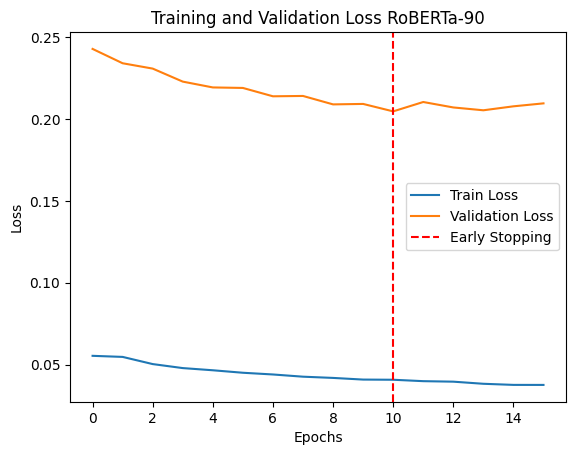

In [132]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {MODEL_NAME}')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

In [133]:
aple_targets, predictions = test(best_model, apl_test_RoBERTA_data)

Mean Squared Error (MSE) on Test Set: 0.2358916805359409


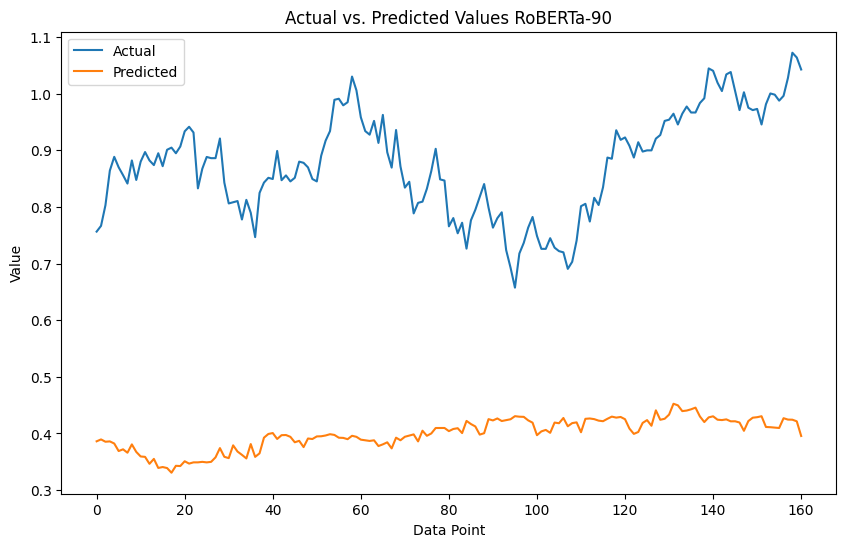

In [134]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values {MODEL_NAME}')
plt.legend()
plt.show()

In [135]:
true_lables, predictions = multi_step_prediction(best_model, apl_test_RoBERTA_data, tokenizer, device, 3)

Mean Squared Error (MSE): 0.2035325425916126


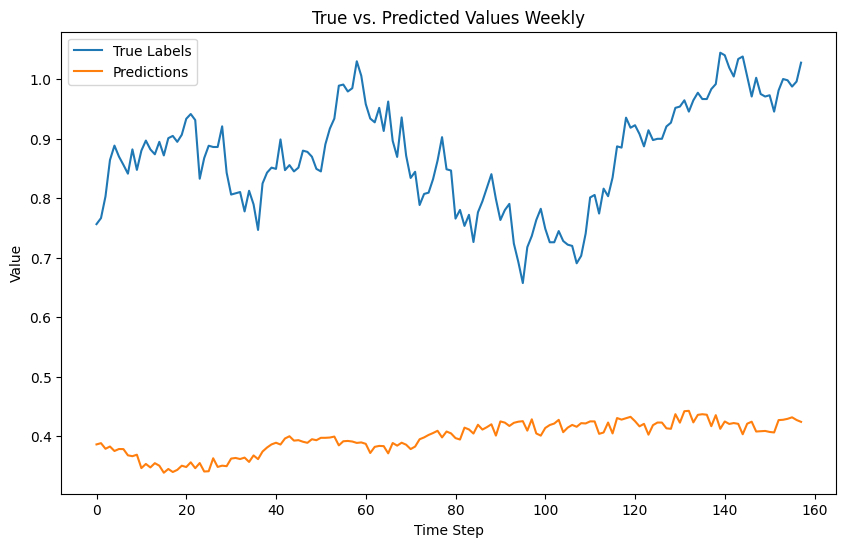

In [136]:
mse = mean_squared_error(true_lables[:7], predictions[:7])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables, label="True Labels")
plt.plot(predictions, label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Weekly")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.2688120764363858


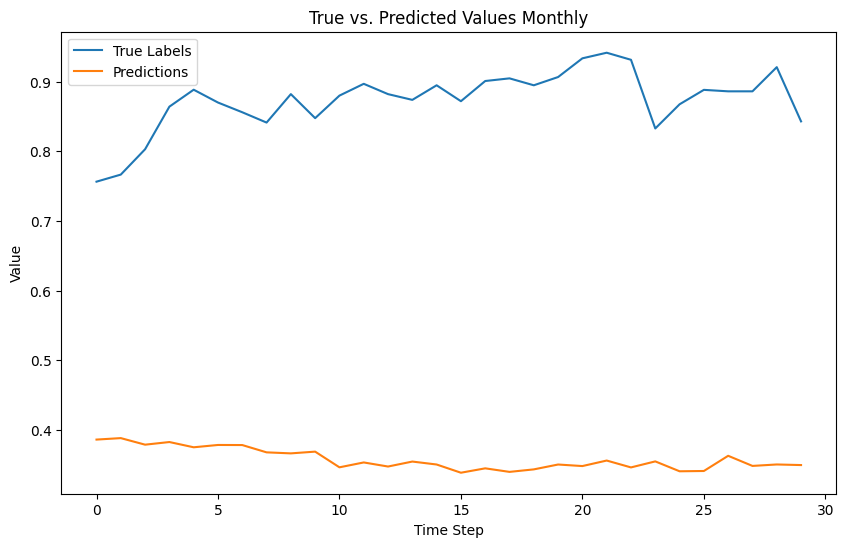

In [137]:
mse = mean_squared_error(true_lables[:30], predictions[:30])
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(10, 6))
plt.plot(true_lables[:30], label="True Labels")
plt.plot(predictions[:30], label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True vs. Predicted Values Monthly")
plt.legend()
plt.show()

# LSTM

In [138]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

Company_payx


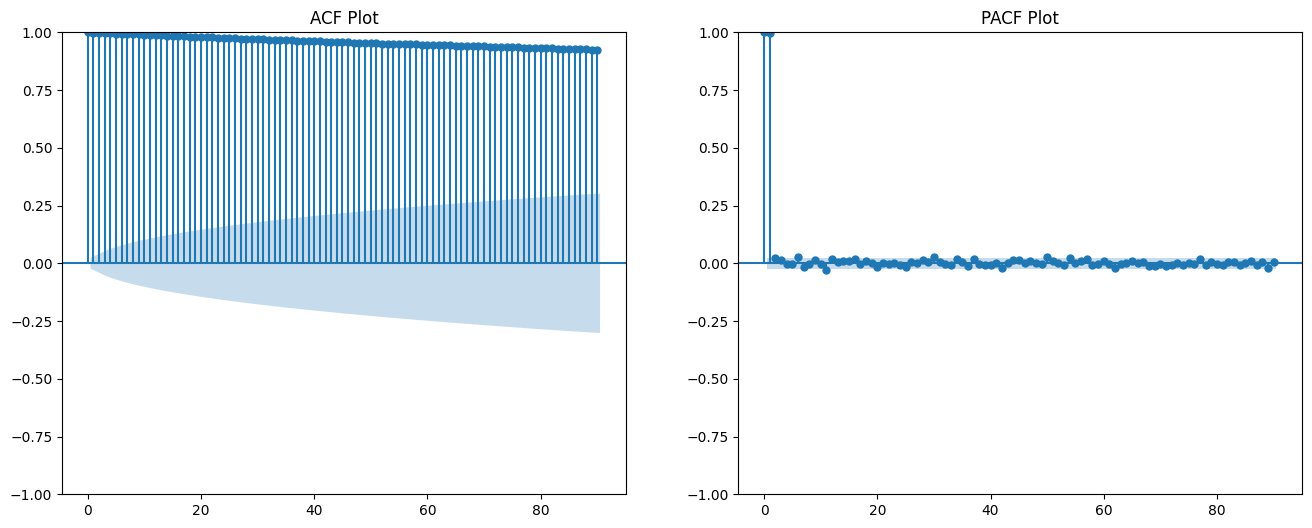

Company_nksh


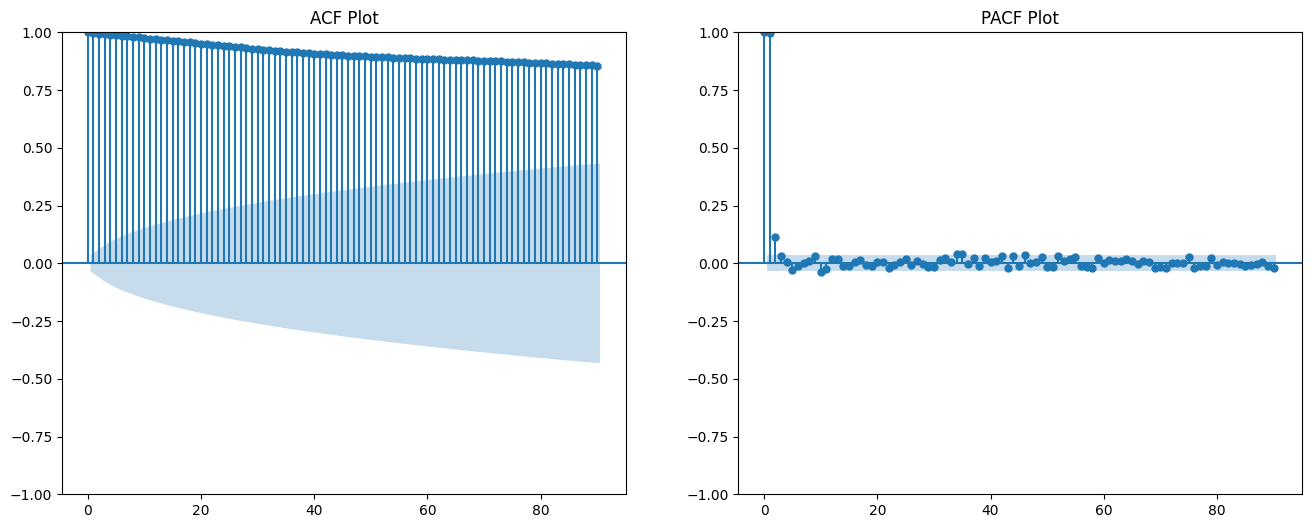

Company_bdge


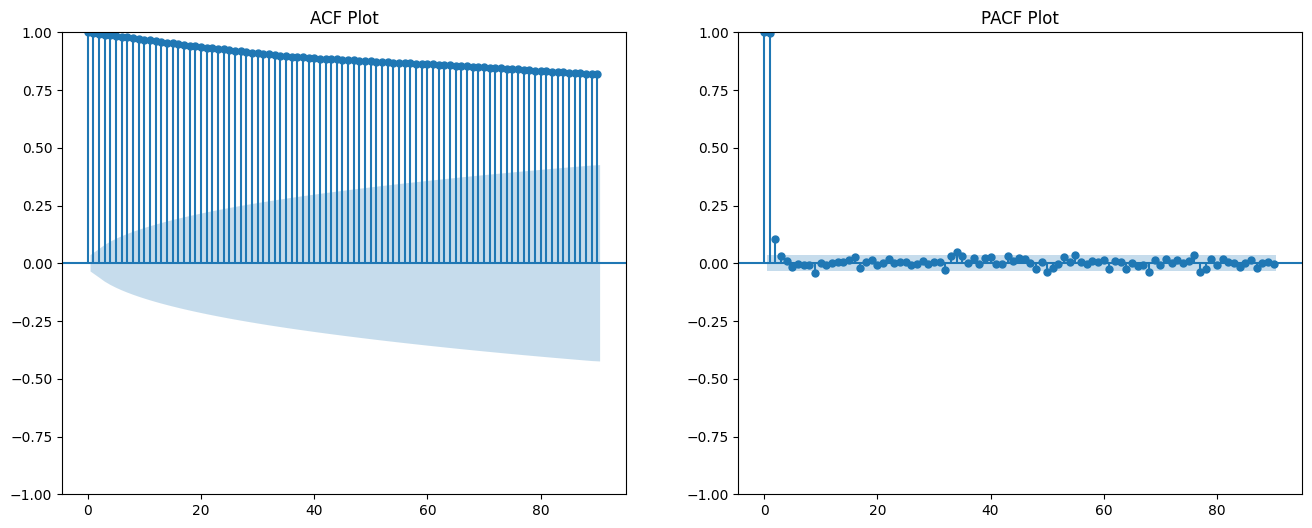

Company_ori


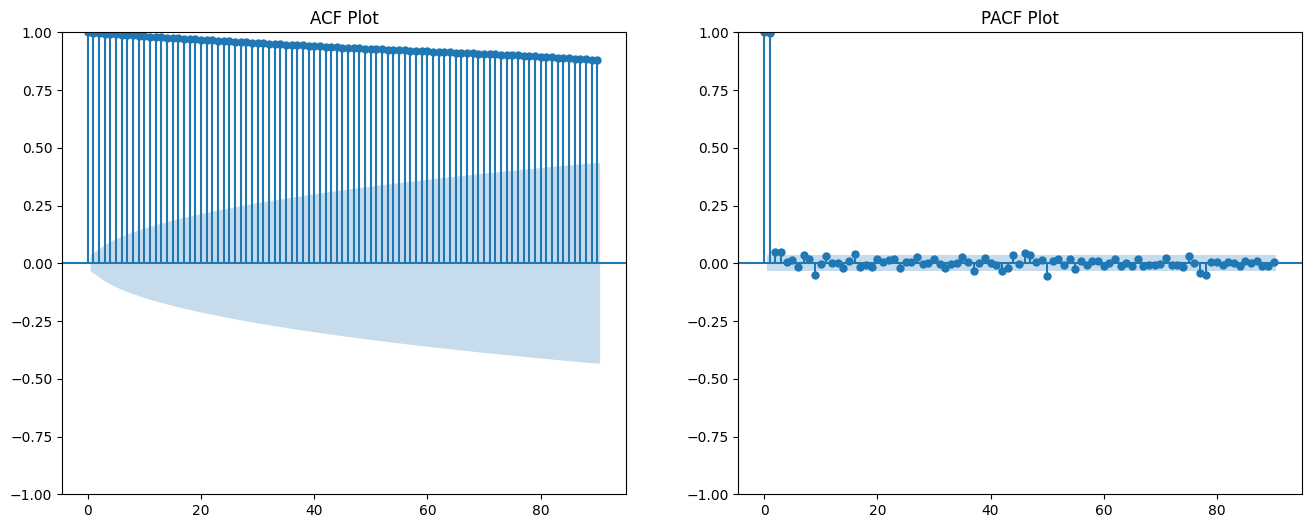

Company_aple


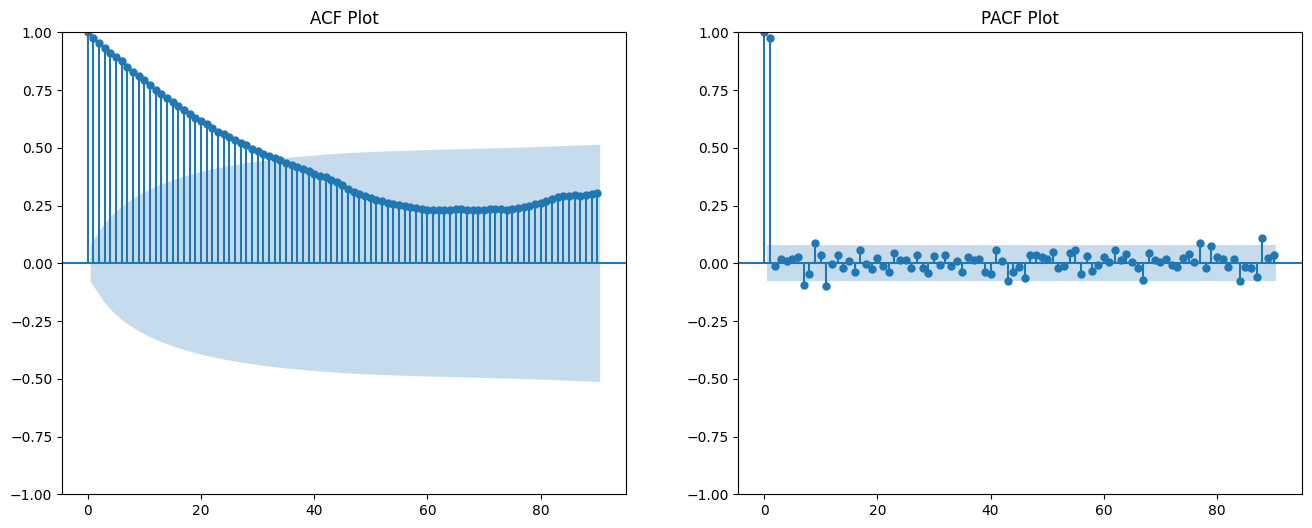

In [139]:
for i, c in enumerate(list(train_data['company_name'].unique())):
  print(f'Company_{c}')
  # Plot ACF and PACF to visualize the optimal lag
  fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  # ACF plot (autocorrelation)
  plot_acf(df.loc[df['company_name']==c,'Close'], ax=axes[0], lags=90)
  axes[0].set_title('ACF Plot')

  # PACF plot (partial autocorrelation)
  plot_pacf(df.loc[df['company_name']==c,'Close'], ax=axes[1], lags=90, method='ywm')
  axes[1].set_title('PACF Plot')

  plt.show()

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the LSTM model
class StockPredictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(StockPredictionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, sequence_length, hidden_size)
        lstm_last_output = lstm_out[:, -1, :]  # Get the last time step output
        prediction = self.fc(lstm_last_output)  # shape: (batch_size, output_size)
        return prediction

In [141]:
def singleStepSampler(df, window, target, cols):
    """
    Generates input-output pairs for time series data using a sliding window approach.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the time series data.
        window (int): Size of the window to create input sequences.
        target (str): Column name of the target variable.
        cols (list): List of column names to include in

    Returns:
        xRes (numpy.ndarray): Array of input sequences of shape (num_samples, window, num_features).
        yRes (numpy.ndarray): Array of target values corresponding to each input sequence.
    """
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in cols:
                r.append(df[col].iloc[i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[target].iloc[i + window])
    return np.array(xRes), np.array(yRes)

In [142]:
def generate_lag_features(df, cols, lag_size):
    """
    Generates lag features for specified columns in a DataFrame.

    Args:
        df: pandas DataFrame containing the time series data.
        cols: List of column names for which to generate lag features.
        lag_size: The number of lagged periods to create.

    Returns:
        pandas DataFrame with added lag features.
    """
    df_res = df.copy()

    for col in cols:
        for i in range(1, lag_size + 1):
            df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
    return df_res

In [143]:
from copy import deepcopy
import time

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for training.")
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU for training.")

# Loss and optimizer
criterion = nn.MSELoss()
criterion.to(device)

def trianer(train_dataloader, val_dataloader, lag_size, hidden_size = 64, num_layers = 2, epochs = 200, patience = 30, lr=1e-6):

  # Model initialization
  input_size = 3 * (1 + lag_size)  # Number of features ("Close", "MACD_Line", "RSI")
  output_size = 1  # Predicting a single value (Close price)

  model = StockPredictionLSTM(input_size, hidden_size, num_layers, output_size)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr, weight_decay=1e-5)

  # Training loop
  train_losses = []
  val_losses = []
  best_val_loss = float("inf")
  epochs_without_improvement = 0
  best_model = None

  print("Training LSTM...")
  st_train = time.time()
  for epoch in range(epochs):
      # Training phase
      model.train()
      total_train_loss = 0
      for inputs, targets in train_dataloader:
          inputs, targets = inputs.to(device), targets.to(device)
          optimizer.zero_grad()
          predictions = model(inputs).squeeze()
          loss = criterion(predictions, targets)
          loss.backward()
          optimizer.step()
          total_train_loss += loss.item()
      fn_train = time.time()

      # Validation phase
      model.eval()
      total_val_loss = 0
      with torch.no_grad():
          for inputs, targets in val_dataloader:
              inputs, targets = inputs.to(device), targets.to(device)
              predictions = model(inputs).squeeze()
              loss = criterion(predictions, targets)
              total_val_loss += loss.item()
      fn_eval = time.time()
      # Logging losses
      avg_train_loss = total_train_loss / len(train_dataloader)
      avg_val_loss = total_val_loss / len(val_dataloader)
      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)


      print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
      print(f"    Training Time: {round((fn_train - st_train)/60, 2)} Min")
      print(f"    Validation Time: {round((fn_eval - fn_train)/60, 2)} Min")

      # Early stopping
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          best_model = deepcopy(model)
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= patience:
              print("Early stopping due to no improvement.")
              break
  return best_model, train_losses, val_losses, epoch, epochs_without_improvement

Using CUDA for training.


In [144]:
# Prepare LSTM-ready data using singleStepSampler
window_size = 15

In [145]:
from sklearn.metrics import mean_squared_error

# Load the best model
def test(model, input_cols):
  model.eval()

  # Prepare test data for LSTM
  aple_inputs, aple_targets = singleStepSampler(lagged_test_data, window_size, target_col, input_cols)
  aple_inputs = torch.tensor(aple_inputs, dtype=torch.float32).to(device)
  aple_targets = torch.tensor(aple_targets, dtype=torch.float32).to(device)

  # Make predictions
  predictions = []
  with torch.no_grad():
      outputs = model(aple_inputs)
      predictions.extend(outputs.cpu().numpy().flatten())

  # Evaluate the model
  mse = mean_squared_error(aple_targets.cpu().numpy(), predictions)
  print(f"Mean Squared Error (MSE) on Test Set: {mse}")
  return aple_targets.cpu(), predictions

In [146]:
import numpy as np

def multistep_predictor(model, input_data, window_size, w, target_col, input_cols):
    """
    Makes multi-step predictions using the given LSTM model and initial input data.

    Args:
    - model: The trained LSTM model.
    - input_data: lagged_test_data
    - window_size: Number of time steps in the window.
    - w: Number of prediction steps (window size).
    - target_col: The name of the target column to predict.
    - input_cols: A list of input column names.

    Returns:
    - predictions: A list of multi-step predictions.
    - real_values: A list of corresponding real values from the target column.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    real_values = []  # To store actual values

    # Get the initial input for the first prediction
    current_input = input_data[input_cols].values[-window_size:].astype(np.float32)

    # Get the actual values for comparison
    actual_values_start_index = len(input_data) - w  # Start index for actual values
    actual_values_end_index = len(input_data)  # End index for actual values

    real_values = input_data[target_col].values[actual_values_start_index:actual_values_end_index].tolist()

    with torch.no_grad():
        for i in range(w):  # w is the number of prediction steps
            # Prepare input for the LSTM model
            current_input_tensor = torch.tensor(current_input, dtype=torch.float32).unsqueeze(0).to(device)

            # Make prediction
            prediction = model(current_input_tensor)
            predictions.append(prediction.item())

            # Update current input with prediction for next step
            current_input = current_input[1:]  # Remove the oldest data point

            # Ensure the new input has the same number of features (12 in this case)
            current_input = np.append(current_input, [[prediction.item()] * len(input_cols)], axis=0)

    return predictions, real_values

## Window Size 3

In [147]:
lag_size = 3
MODEL_NAME = f"LSTM-{lag_size}"

### Creating Lagged Features

In [148]:
lagged_train_data = generate_lag_features(train_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_val_data = generate_lag_features(val_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_test_data = generate_lag_features(aple_test, ["Close", "MACD_Line", "RSI"], lag_size)

<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393

In [149]:
input_cols = ["Close", "MACD_Line", "RSI"]
lagged_inputs = []

for c in input_cols:
  for w in range(1, lag_size+1):
    lagged_inputs.append(f'{c}_lag_{w}')

input_cols.extend(lagged_inputs)

target_col = "Close"

train_inputs, train_targets = singleStepSampler(lagged_train_data, window_size, target_col, input_cols)
val_inputs, val_targets = singleStepSampler(lagged_val_data, window_size, target_col, input_cols)

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training

In [150]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trianer(train_dataloader, val_dataloader, lag_size)

Training LSTM...
Epoch 1/200 - Train Loss: 0.1264, Val Loss: 0.4410
    Training Time: 0.02 Min
    Validation Time: 0.0 Min
Epoch 2/200 - Train Loss: 0.1167, Val Loss: 0.4205
    Training Time: 0.05 Min
    Validation Time: 0.0 Min
Epoch 3/200 - Train Loss: 0.1083, Val Loss: 0.4010
    Training Time: 0.07 Min
    Validation Time: 0.0 Min
Epoch 4/200 - Train Loss: 0.1005, Val Loss: 0.3821
    Training Time: 0.09 Min
    Validation Time: 0.0 Min
Epoch 5/200 - Train Loss: 0.0930, Val Loss: 0.3634
    Training Time: 0.11 Min
    Validation Time: 0.0 Min
Epoch 6/200 - Train Loss: 0.0859, Val Loss: 0.3450
    Training Time: 0.14 Min
    Validation Time: 0.0 Min
Epoch 7/200 - Train Loss: 0.0792, Val Loss: 0.3267
    Training Time: 0.16 Min
    Validation Time: 0.0 Min
Epoch 8/200 - Train Loss: 0.0728, Val Loss: 0.3085
    Training Time: 0.18 Min
    Validation Time: 0.0 Min
Epoch 9/200 - Train Loss: 0.0668, Val Loss: 0.2907
    Training Time: 0.2 Min
    Validation Time: 0.0 Min
Epoch 10/200

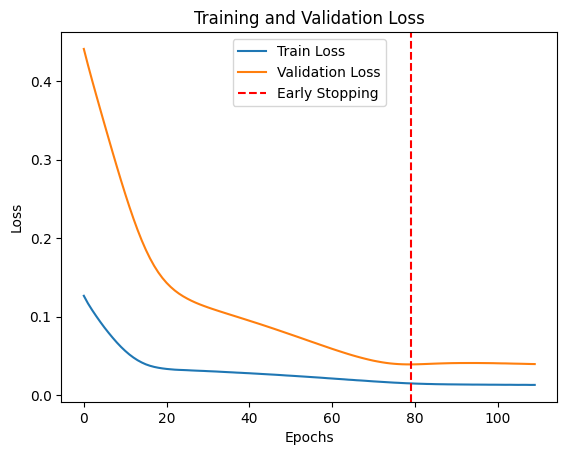

In [151]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

### Testing Single Step Prediction

In [152]:
aple_targets, predictions = test(best_model, input_cols)

Mean Squared Error (MSE) on Test Set: 0.008203796111047268


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


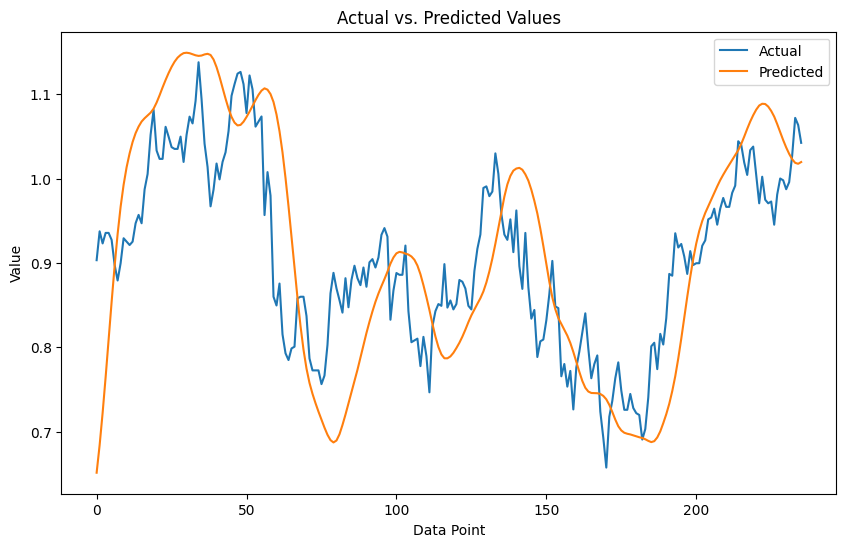

In [153]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

### Testing 7-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


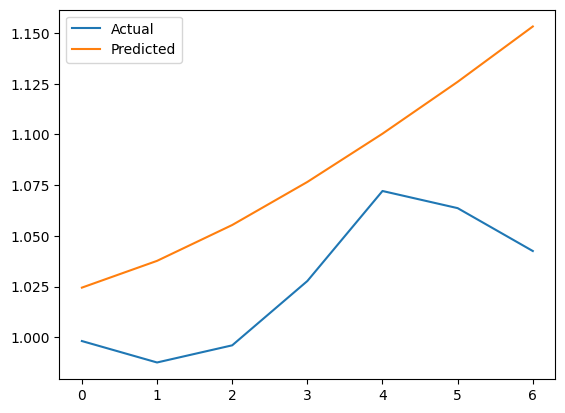

In [154]:
# Assume 'lagged_test_data', 'window_size', 'w', 'target_col', and 'input_cols' are defined
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 7, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [155]:
# Compute and print MSE for the 7-day prediction
mse_7day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 7-day prediction: {mse_7day}")

Mean Squared Error (MSE) for 7-day prediction: 0.0037252165272087185


### Testing 30-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


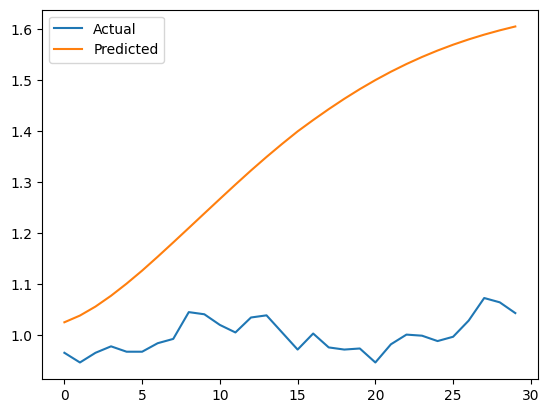

In [156]:
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 30, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [157]:
# Compute and print MSE for the 30-day prediction
mse_30day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 30-day prediction: {mse_30day}")

Mean Squared Error (MSE) for 30-day prediction: 0.15870763658325385


## Window Size 7

In [158]:
lag_size = 7
MODEL_NAME = f"LSTM-{lag_size}"

### Creating Lagged Features

In [159]:
lagged_train_data = generate_lag_features(train_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_val_data = generate_lag_features(val_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_test_data = generate_lag_features(aple_test, ["Close", "MACD_Line", "RSI"], lag_size)

<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393

In [160]:
input_cols = ["Close", "MACD_Line", "RSI"]
lagged_inputs = []

for c in input_cols:
  for w in range(1, lag_size+1):
    lagged_inputs.append(f'{c}_lag_{w}')

input_cols.extend(lagged_inputs)

target_col = "Close"

train_inputs, train_targets = singleStepSampler(lagged_train_data, window_size, target_col, input_cols)
val_inputs, val_targets = singleStepSampler(lagged_val_data, window_size, target_col, input_cols)

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training

In [161]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trianer(train_dataloader, val_dataloader, lag_size)

Training LSTM...
Epoch 1/200 - Train Loss: 0.2504, Val Loss: 0.6684
    Training Time: 0.02 Min
    Validation Time: 0.0 Min
Epoch 2/200 - Train Loss: 0.2343, Val Loss: 0.6389
    Training Time: 0.05 Min
    Validation Time: 0.0 Min
Epoch 3/200 - Train Loss: 0.2192, Val Loss: 0.6095
    Training Time: 0.07 Min
    Validation Time: 0.0 Min
Epoch 4/200 - Train Loss: 0.2042, Val Loss: 0.5797
    Training Time: 0.09 Min
    Validation Time: 0.0 Min
Epoch 5/200 - Train Loss: 0.1892, Val Loss: 0.5490
    Training Time: 0.11 Min
    Validation Time: 0.0 Min
Epoch 6/200 - Train Loss: 0.1739, Val Loss: 0.5170
    Training Time: 0.14 Min
    Validation Time: 0.0 Min
Epoch 7/200 - Train Loss: 0.1583, Val Loss: 0.4837
    Training Time: 0.16 Min
    Validation Time: 0.0 Min
Epoch 8/200 - Train Loss: 0.1427, Val Loss: 0.4492
    Training Time: 0.18 Min
    Validation Time: 0.0 Min
Epoch 9/200 - Train Loss: 0.1271, Val Loss: 0.4137
    Training Time: 0.21 Min
    Validation Time: 0.0 Min
Epoch 10/20

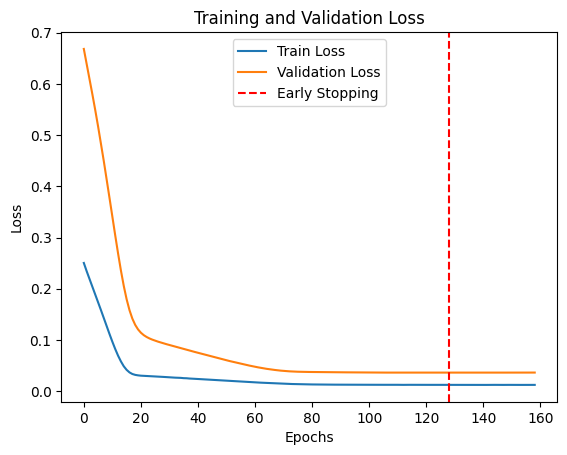

In [162]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

### Testing Single Step Prediction

In [163]:
aple_targets, predictions = test(best_model, input_cols)

Mean Squared Error (MSE) on Test Set: 0.008211741223931313


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


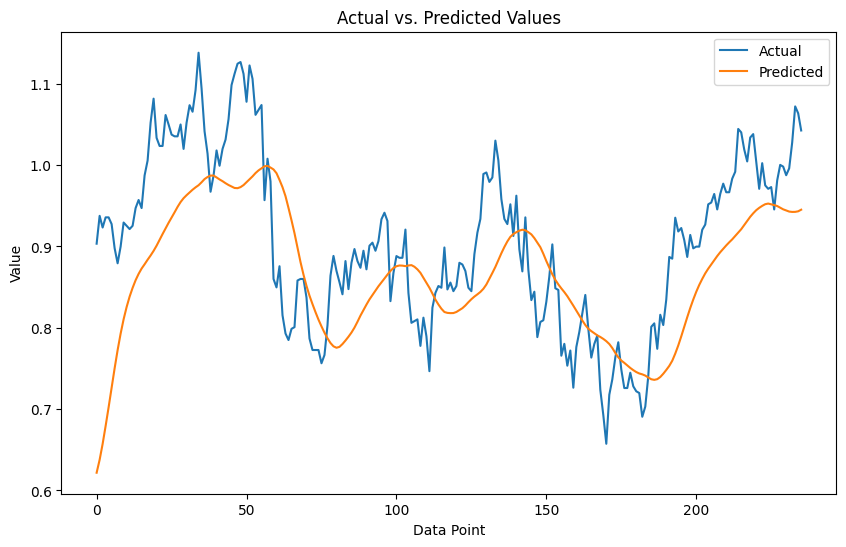

In [164]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

### Testing 7-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


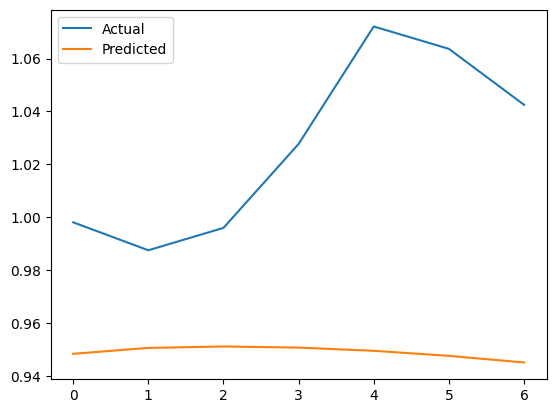

In [165]:
# Assume 'lagged_test_data', 'window_size', 'w', 'target_col', and 'input_cols' are defined
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 7, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [166]:
# Compute and print MSE for the 7-day prediction
mse_7day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 7-day prediction: {mse_7day}")

Mean Squared Error (MSE) for 7-day prediction: 0.007108706641197159


### Testing 30-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


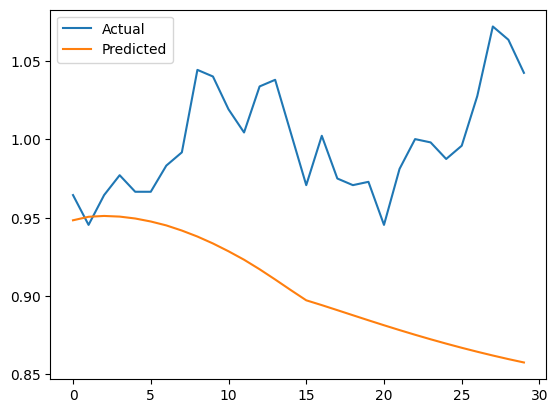

In [167]:
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 30, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [168]:
# Compute and print MSE for the 30-day prediction
mse_30day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 30-day prediction: {mse_30day}")

Mean Squared Error (MSE) for 30-day prediction: 0.011513235406287953


## Window Size 15

In [169]:
lag_size = 15
MODEL_NAME = f"LSTM-{lag_size}"

### Creating Lagged Features

In [170]:
lagged_train_data = generate_lag_features(train_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_val_data = generate_lag_features(val_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_test_data = generate_lag_features(aple_test, ["Close", "MACD_Line", "RSI"], lag_size)

<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393

In [171]:
input_cols = ["Close", "MACD_Line", "RSI"]
lagged_inputs = []

for c in input_cols:
  for w in range(1, lag_size+1):
    lagged_inputs.append(f'{c}_lag_{w}')

input_cols.extend(lagged_inputs)

target_col = "Close"

train_inputs, train_targets = singleStepSampler(lagged_train_data, window_size, target_col, input_cols)
val_inputs, val_targets = singleStepSampler(lagged_val_data, window_size, target_col, input_cols)

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training

In [172]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trianer(train_dataloader, val_dataloader, lag_size)

Training LSTM...
Epoch 1/200 - Train Loss: 0.0687, Val Loss: 0.2962
    Training Time: 0.02 Min
    Validation Time: 0.0 Min
Epoch 2/200 - Train Loss: 0.0614, Val Loss: 0.2754
    Training Time: 0.04 Min
    Validation Time: 0.0 Min
Epoch 3/200 - Train Loss: 0.0558, Val Loss: 0.2566
    Training Time: 0.07 Min
    Validation Time: 0.0 Min
Epoch 4/200 - Train Loss: 0.0510, Val Loss: 0.2393
    Training Time: 0.09 Min
    Validation Time: 0.0 Min
Epoch 5/200 - Train Loss: 0.0470, Val Loss: 0.2233
    Training Time: 0.11 Min
    Validation Time: 0.0 Min
Epoch 6/200 - Train Loss: 0.0437, Val Loss: 0.2087
    Training Time: 0.14 Min
    Validation Time: 0.0 Min
Epoch 7/200 - Train Loss: 0.0409, Val Loss: 0.1955
    Training Time: 0.16 Min
    Validation Time: 0.0 Min
Epoch 8/200 - Train Loss: 0.0388, Val Loss: 0.1836
    Training Time: 0.19 Min
    Validation Time: 0.0 Min
Epoch 9/200 - Train Loss: 0.0370, Val Loss: 0.1731
    Training Time: 0.21 Min
    Validation Time: 0.0 Min
Epoch 10/20

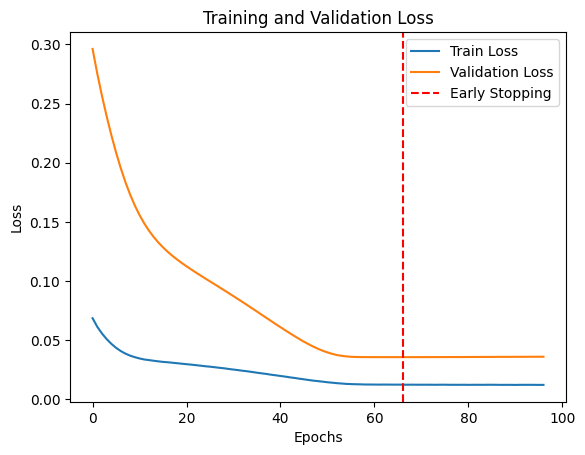

In [173]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

### Testing Single Step Prediction

In [174]:
aple_targets, predictions = test(best_model, input_cols)

Mean Squared Error (MSE) on Test Set: 0.009103694930672646


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


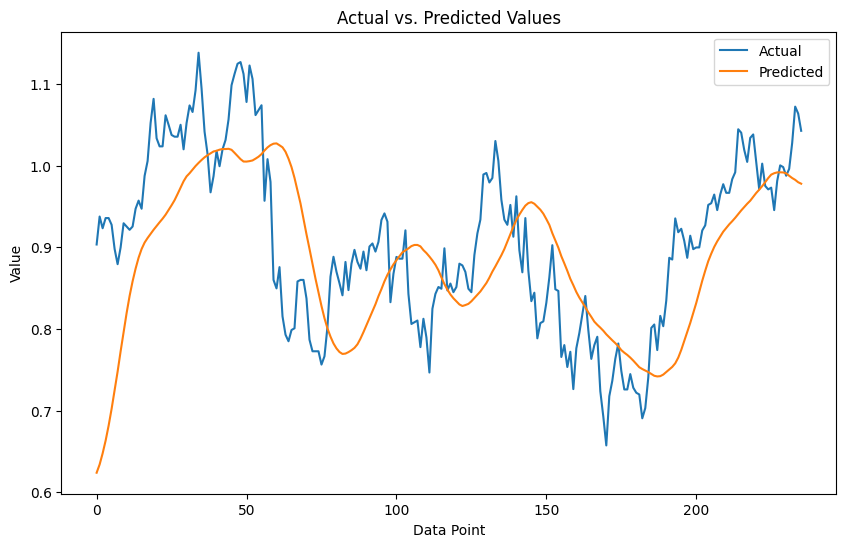

In [175]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

### Testing 7-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


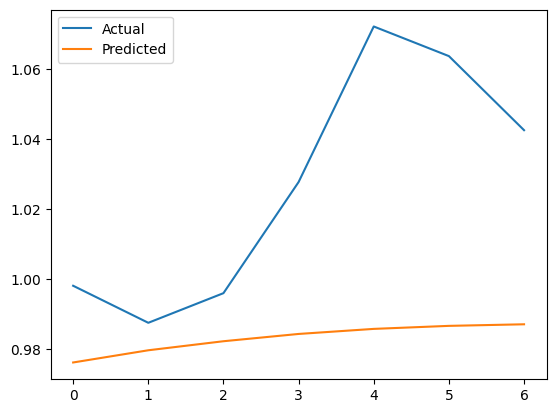

In [176]:
# Assume 'lagged_test_data', 'window_size', 'w', 'target_col', and 'input_cols' are defined
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 7, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [177]:
# Compute and print MSE for the 7-day prediction
mse_7day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 7-day prediction: {mse_7day}")

Mean Squared Error (MSE) for 7-day prediction: 0.0027241180432093872


### Testing 30-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


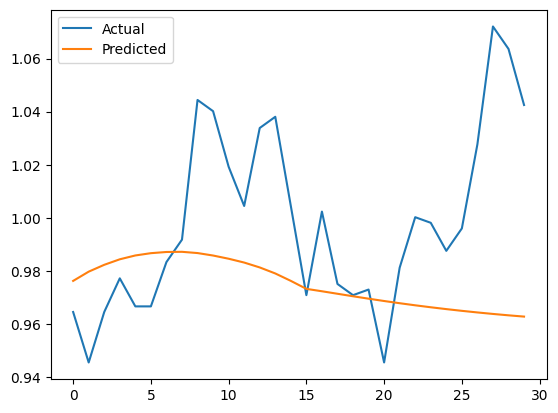

In [178]:
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 30, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [179]:
# Compute and print MSE for the 30-day prediction
mse_30day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 30-day prediction: {mse_30day}")

Mean Squared Error (MSE) for 30-day prediction: 0.0018310541807447197


## Window Size 30

In [180]:
lag_size = 30
MODEL_NAME = f"LSTM-{lag_size}"

### Creating Lagged Features

In [181]:
lagged_train_data = generate_lag_features(train_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_val_data = generate_lag_features(val_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_test_data = generate_lag_features(aple_test, ["Close", "MACD_Line", "RSI"], lag_size)

<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393

In [182]:
input_cols = ["Close", "MACD_Line", "RSI"]
lagged_inputs = []

for c in input_cols:
  for w in range(1, lag_size+1):
    lagged_inputs.append(f'{c}_lag_{w}')

input_cols.extend(lagged_inputs)

target_col = "Close"

train_inputs, train_targets = singleStepSampler(lagged_train_data, window_size, target_col, input_cols)
val_inputs, val_targets = singleStepSampler(lagged_val_data, window_size, target_col, input_cols)

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training

In [183]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trianer(train_dataloader, val_dataloader, lag_size)

Training LSTM...
Epoch 1/200 - Train Loss: 0.0920, Val Loss: 0.3543
    Training Time: 0.02 Min
    Validation Time: 0.0 Min
Epoch 2/200 - Train Loss: 0.0792, Val Loss: 0.3231
    Training Time: 0.05 Min
    Validation Time: 0.0 Min
Epoch 3/200 - Train Loss: 0.0690, Val Loss: 0.2946
    Training Time: 0.07 Min
    Validation Time: 0.0 Min
Epoch 4/200 - Train Loss: 0.0603, Val Loss: 0.2679
    Training Time: 0.09 Min
    Validation Time: 0.0 Min
Epoch 5/200 - Train Loss: 0.0528, Val Loss: 0.2431
    Training Time: 0.12 Min
    Validation Time: 0.0 Min
Epoch 6/200 - Train Loss: 0.0467, Val Loss: 0.2204
    Training Time: 0.14 Min
    Validation Time: 0.0 Min
Epoch 7/200 - Train Loss: 0.0417, Val Loss: 0.2002
    Training Time: 0.17 Min
    Validation Time: 0.0 Min
Epoch 8/200 - Train Loss: 0.0379, Val Loss: 0.1826
    Training Time: 0.19 Min
    Validation Time: 0.0 Min
Epoch 9/200 - Train Loss: 0.0352, Val Loss: 0.1675
    Training Time: 0.22 Min
    Validation Time: 0.0 Min
Epoch 10/20

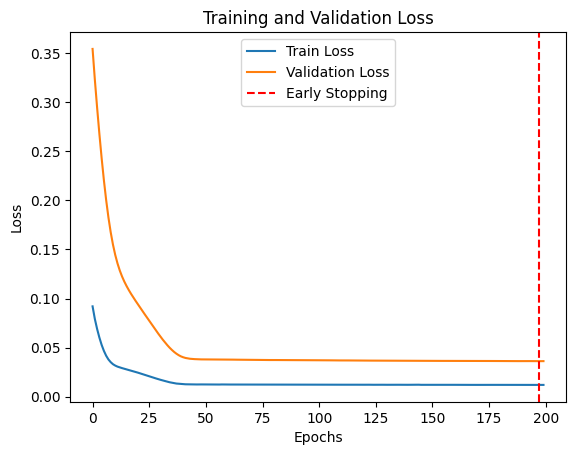

In [184]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

### Testing Single Step Prediction

In [185]:
aple_targets, predictions = test(best_model, input_cols)

Mean Squared Error (MSE) on Test Set: 0.01680455356836319


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


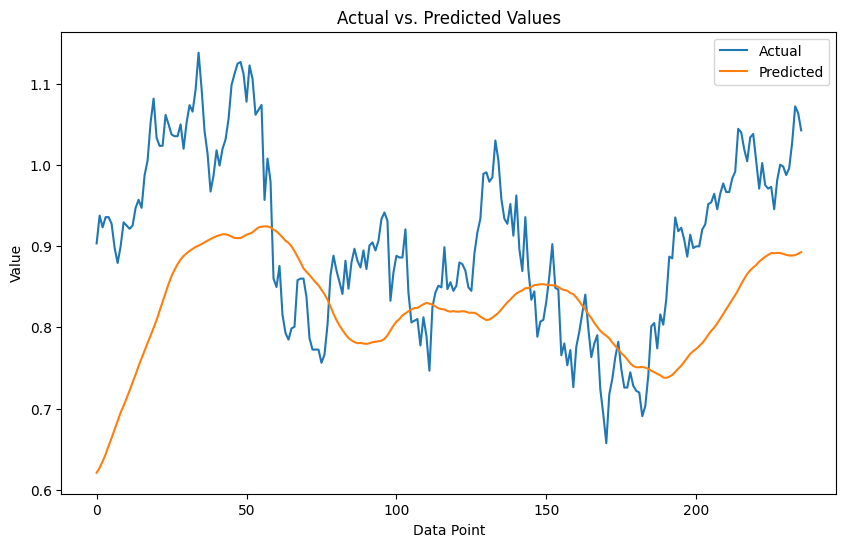

In [186]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

### Testing 7-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


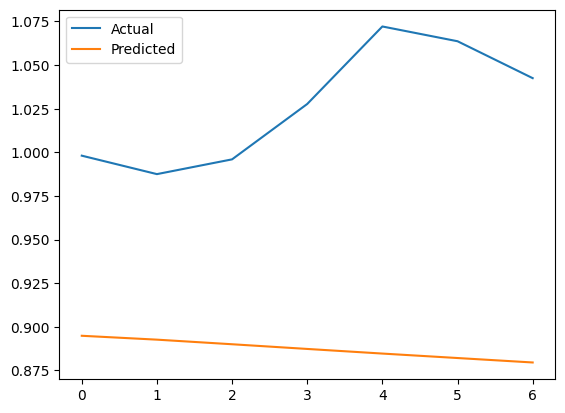

In [187]:
# Assume 'lagged_test_data', 'window_size', 'w', 'target_col', and 'input_cols' are defined
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 7, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [188]:
# Compute and print MSE for the 7-day prediction
mse_7day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 7-day prediction: {mse_7day}")

Mean Squared Error (MSE) for 7-day prediction: 0.020742487865587158


### Testing 30-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


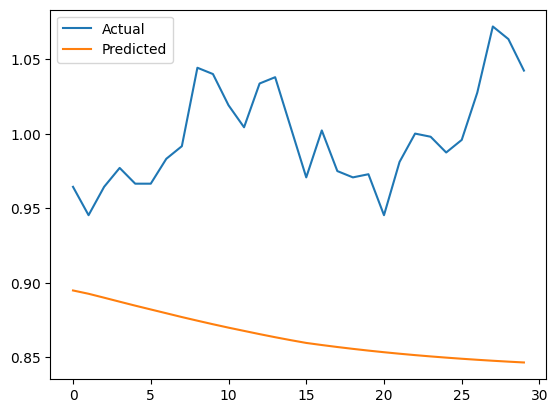

In [189]:
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 30, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [190]:
# Compute and print MSE for the 30-day prediction
mse_30day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 30-day prediction: {mse_30day}")

Mean Squared Error (MSE) for 30-day prediction: 0.019595750088465976


## Window Size 90

In [191]:
lag_size = 90
MODEL_NAME = f"LSTM-{lag_size}"

### Creating Lagged Features

In [192]:
lagged_train_data = generate_lag_features(train_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_val_data = generate_lag_features(val_data, ["Close", "MACD_Line", "RSI"], lag_size)
lagged_test_data = generate_lag_features(aple_test, ["Close", "MACD_Line", "RSI"], lag_size)

<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393279>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_res[f'{col}_lag_{i}'] = df_res[col].shift(i).fillna(method='bfill')
<ipython-input-142-97c6ac393

In [193]:
input_cols = ["Close", "MACD_Line", "RSI"]
lagged_inputs = []

for c in input_cols:
  for w in range(1, lag_size+1):
    lagged_inputs.append(f'{c}_lag_{w}')

input_cols.extend(lagged_inputs)

target_col = "Close"

train_inputs, train_targets = singleStepSampler(lagged_train_data, window_size, target_col, input_cols)
val_inputs, val_targets = singleStepSampler(lagged_val_data, window_size, target_col, input_cols)

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training

In [194]:
best_model, train_losses, val_losses, epoch, epochs_without_improvement = trianer(train_dataloader, val_dataloader, lag_size)

Training LSTM...
Epoch 1/200 - Train Loss: 0.2404, Val Loss: 0.5854
    Training Time: 0.02 Min
    Validation Time: 0.0 Min
Epoch 2/200 - Train Loss: 0.1917, Val Loss: 0.4992
    Training Time: 0.05 Min
    Validation Time: 0.0 Min
Epoch 3/200 - Train Loss: 0.1497, Val Loss: 0.4171
    Training Time: 0.08 Min
    Validation Time: 0.0 Min
Epoch 4/200 - Train Loss: 0.1122, Val Loss: 0.3406
    Training Time: 0.1 Min
    Validation Time: 0.0 Min
Epoch 5/200 - Train Loss: 0.0809, Val Loss: 0.2732
    Training Time: 0.13 Min
    Validation Time: 0.0 Min
Epoch 6/200 - Train Loss: 0.0569, Val Loss: 0.2173
    Training Time: 0.15 Min
    Validation Time: 0.0 Min
Epoch 7/200 - Train Loss: 0.0407, Val Loss: 0.1736
    Training Time: 0.18 Min
    Validation Time: 0.0 Min
Epoch 8/200 - Train Loss: 0.0311, Val Loss: 0.1419
    Training Time: 0.2 Min
    Validation Time: 0.0 Min
Epoch 9/200 - Train Loss: 0.0264, Val Loss: 0.1203
    Training Time: 0.23 Min
    Validation Time: 0.0 Min
Epoch 10/200 

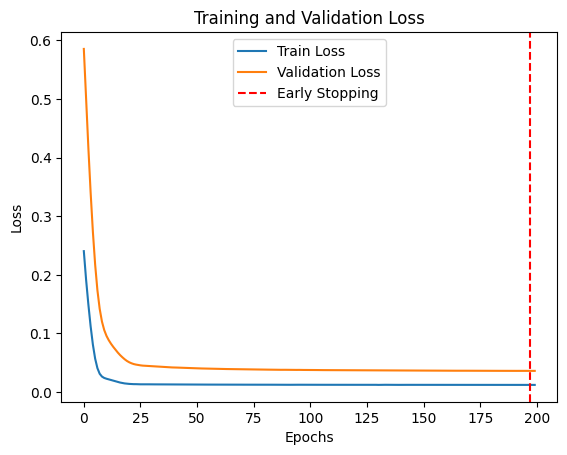

In [195]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(epoch+1), train_losses, label='Train Loss')
plt.plot(range(epoch+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
# Add a vertical line to indicate early stopping
plt.axvline(x=epoch - epochs_without_improvement, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

### Testing Single Step Prediction

In [196]:
aple_targets, predictions = test(best_model, input_cols)

Mean Squared Error (MSE) on Test Set: 0.028117109090089798


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


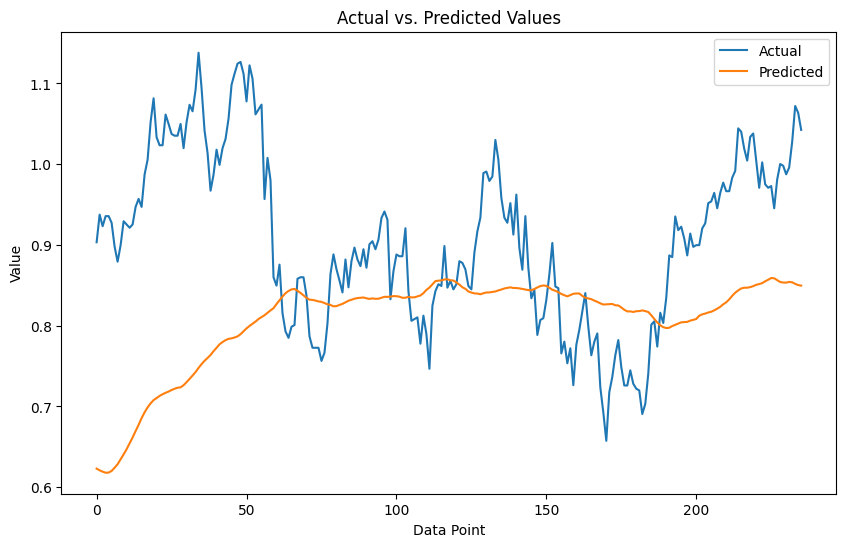

In [197]:
# prompt: plot predicted data and real data in a plot

import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(aple_targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

### Testing 7-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


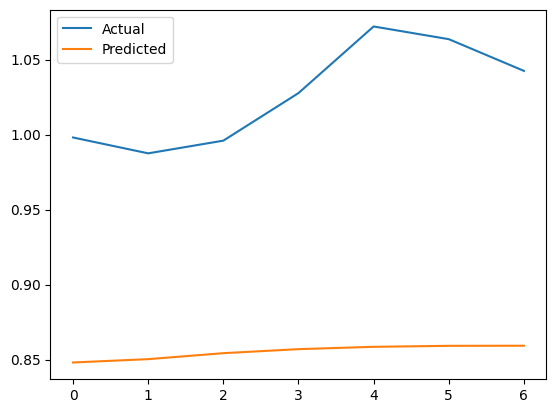

In [198]:
# Assume 'lagged_test_data', 'window_size', 'w', 'target_col', and 'input_cols' are defined
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 7, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [199]:
# Compute and print MSE for the 7-day prediction
mse_7day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 7-day prediction: {mse_7day}")

Mean Squared Error (MSE) for 7-day prediction: 0.030234612999230914


### Testing 30-day Prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


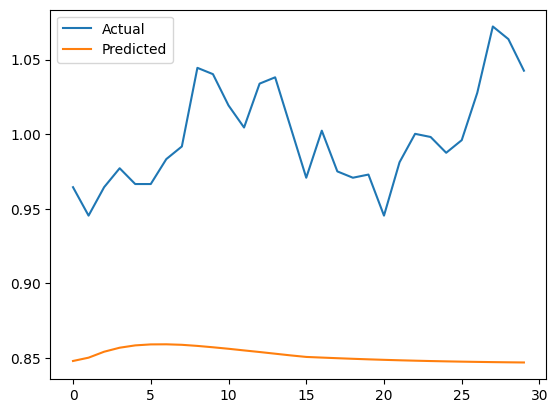

In [200]:
predictions, real_values = multistep_predictor(best_model, lagged_test_data, window_size, 30, target_col, input_cols)

# Now you can plot both predictions and real_values for comparison
import matplotlib.pyplot as plt

plt.plot(real_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [201]:
# Compute and print MSE for the 30-day prediction
mse_30day = mean_squared_error(real_values, predictions)
print(f"Mean Squared Error (MSE) for 30-day prediction: {mse_30day}")

Mean Squared Error (MSE) for 30-day prediction: 0.022593009579615398
